## Read in the appropriate packages

In [1]:
#conda install -c conda-forge frozendict
#conda install -c conda-forge yfinance

In [2]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import yfinance as yf
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series


## White Noise

White noise is an important concept in time series forecasting. It is important for two main reasons:
1. Predictability: If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions.
2. Model Diagnostics: The series of errors from a time series forecast model should ideally be white noise.

Model Diagnostics is an important area of time series forecasting.

Time series data are expected to contain some white noise component on top of the signal generated by the underlying process.

y(t) = signal(t) + noise(t)

Once predictions have been made by a time series forecast model, they can be collected and analyzed. The series of forecast errors should ideally be white noise.

When forecast errors are white noise, it means that all of the signal information in the time series has been harnessed by the model in order to make predictions. All that is left is the random fluctuations that cannot be modeled.

A sign that model predictions are not white noise is an indication that further improvements to the forecast model may be possible.

How to know if a time series is white noise or not? A time series is probably NOT white noise if one or more of the following conditions are true:

1. Is the mean/level non-zero?
2. Does the mean/level change over time?
3. Does the variance change over time?
4. Do values correlate with lag values?

Some tools that you can use to check if your time series is white noise are:

1. Create a line plot. Check for gross features like a changing mean, variance, or obvious relationship between lagged variables.
2. Calculate summary statistics. Check the mean and variance.
3. Create an autocorrelation plot. Check for gross correlation between lagged variables.

Let us create a Gaussian white noise series and perform some checks.

It is helpful to create and review a white noise time series in practice. It will provide the frame of reference and example plots and statistical tests to use and compare on your own time series projects to check if they are white noise.

Source: https://machinelearningmastery.com/white-noise-time-series-python/

In [3]:
# First, we can create a list of 1,000 random Gaussian variables using the gauss() function from the random module.
# We will draw variables from a Gaussian distribution with a mean (mu) of 0.0 and a standard deviation (sigma) of 1.0.
#Once created, we can wrap the list in a Pandas Series for convenience.

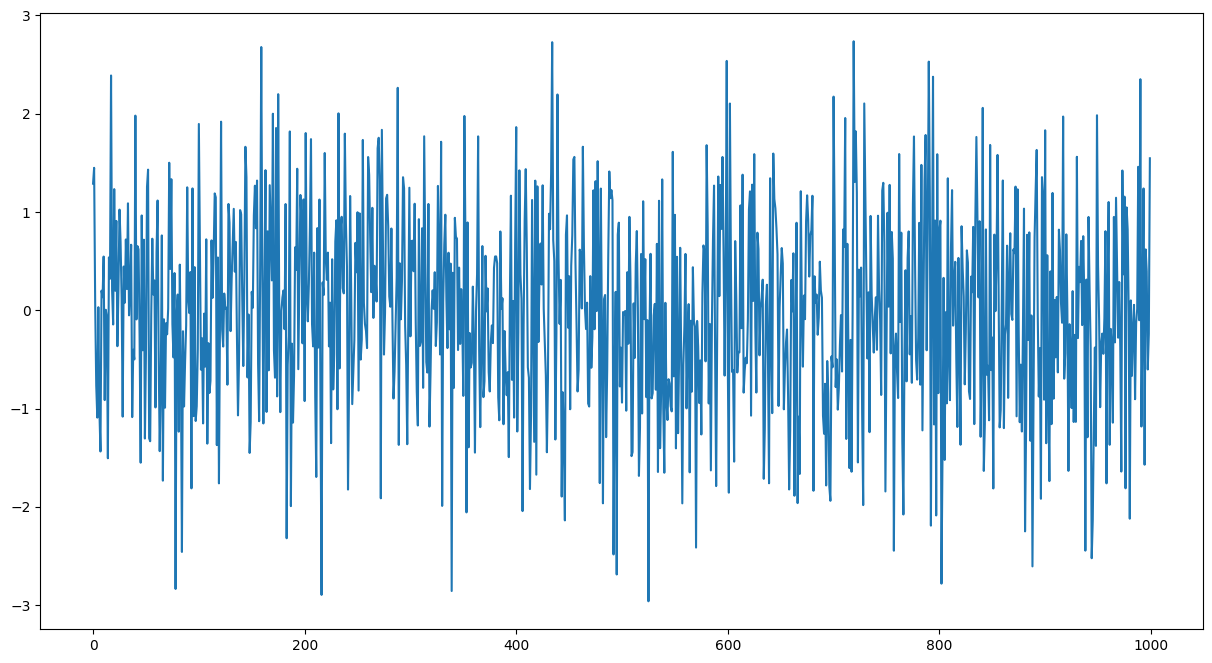

In [4]:
# seed random number generator
seed(1)
# create white noise series
series = [gauss(0.0, 1.0) for i in range(1000)]
series = Series(series)

# line plot
plt.figure(figsize=(15,8))
series.plot()
plt.show()

In [5]:
# Next, we can calculate and print some summary statistics, including the mean and standard deviation of the series.

# summary stats
series.describe()

,0
count,1000.000000
mean,-0.013222
std,1.003685
min,-2.961214
25%,-0.684192
50%,-0.010934
75%,0.703915
max,2.737260


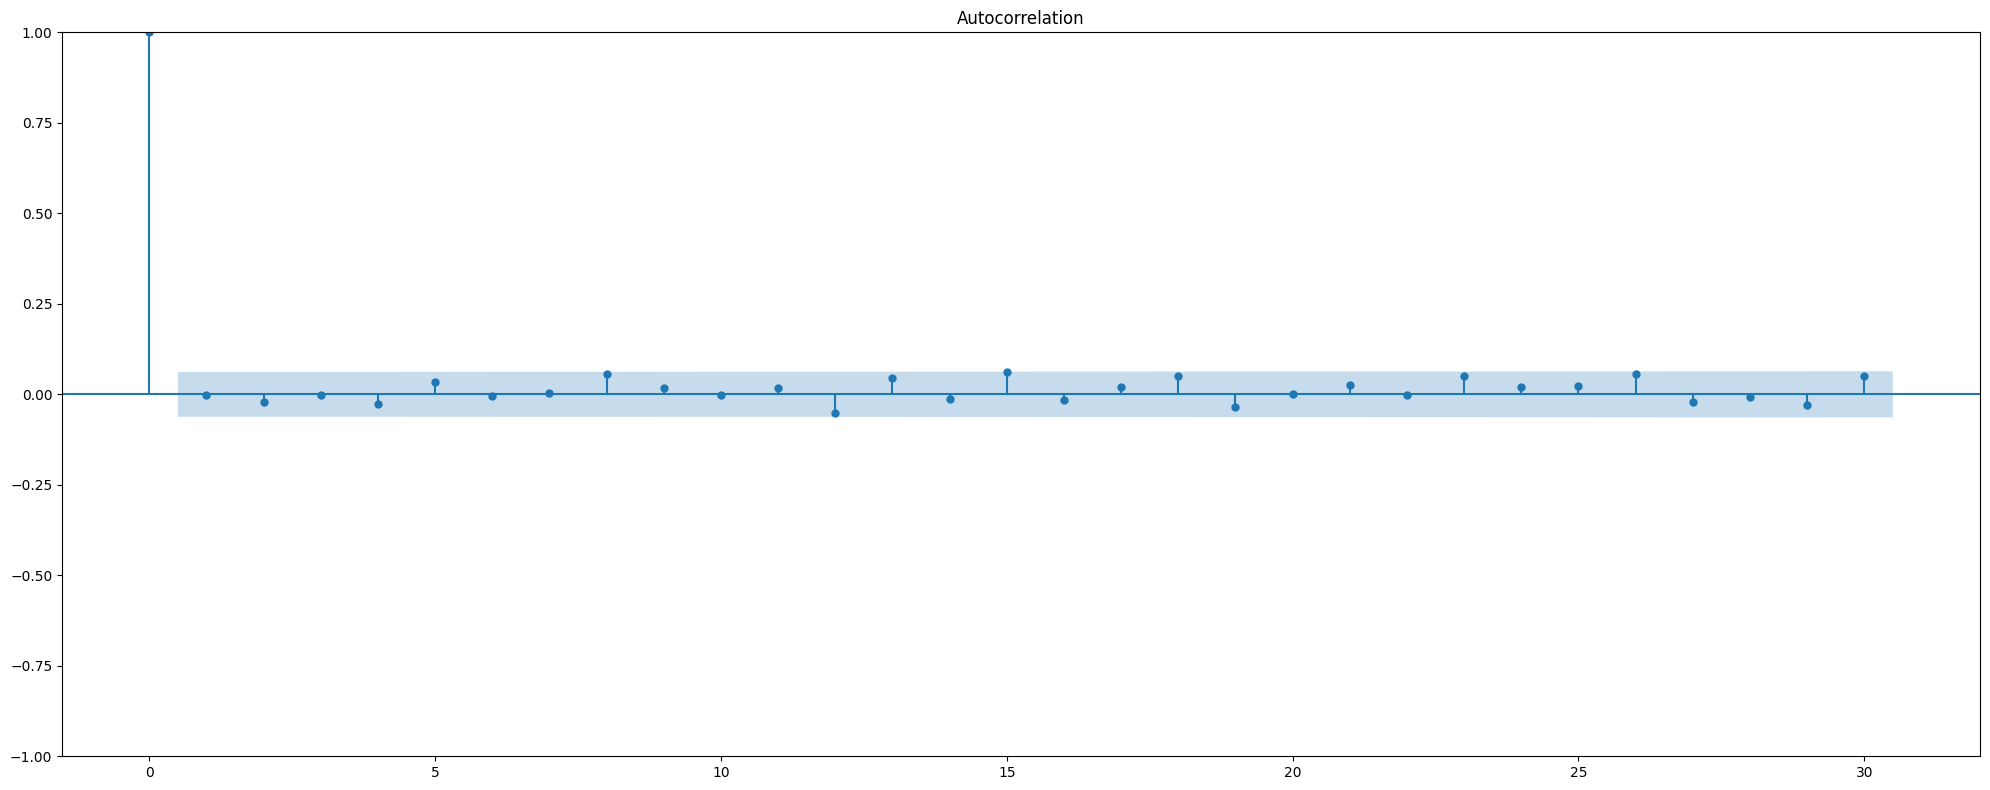

In [6]:
# autocorrelation plot - see slides

fig = plot_acf(series, lags=30) #print only 30 lags
fig.set_size_inches((20,8))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In summary:

1. White noise time series is defined by a zero mean, constant variance, and zero correlation.
2. If your time series is white noise, it cannot be predicted, and if your forecast residuals are not white noise, you may be able to improve your model.
3. Descriptive statistics and plots such as autocorrelation, line plots, and residual plots can be used on your time series to check if it is white noise.

## 1. Download stock data - single and multiple and get it into the right format

A way of getting the historical stock data is to use the pandas_datareader library.
It uses Yahoo’s Finance API to load in the data.

### First, download SINGLE stock using pandas_datareader

In [7]:
# Define stock ticker and date range
stock_ticker = 'MSFT'
stock_start_date = datetime.date(2013,12,29)
stock_end_date = datetime.date.today()

# Fetch the stock price from Yahoo Finance using yfinance
stock_df = yf.download(stock_ticker, start=stock_start_date, end=stock_end_date)

[*********************100%***********************]  1 of 1 completed


In [8]:
stock_df

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2013-12-30,31.167217,31.242440,30.841253,31.108711,16290500
2013-12-31,31.267527,31.409615,31.108725,31.259170,17503500
2014-01-02,31.058577,31.259172,31.008427,31.217379,30632200
2014-01-03,30.849609,31.108710,30.590508,31.091994,31134800
2014-01-06,30.197685,30.832897,30.180969,30.799464,43603700
...,...,...,...,...,...
2025-01-14,415.670013,419.739990,410.720001,417.809998,16935900
2025-01-15,426.309998,428.149994,418.269989,419.130005,19637800


In [9]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2782 entries, 2013-12-30 to 2025-01-21
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, MSFT)   2782 non-null   float64
 1   (High, MSFT)    2782 non-null   float64
 2   (Low, MSFT)     2782 non-null   float64
 3   (Open, MSFT)    2782 non-null   float64
 4   (Volume, MSFT)  2782 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 130.4 KB


In [10]:
stock_df.index

DatetimeIndex(['2013-12-30', '2013-12-31', '2014-01-02', '2014-01-03',
               '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09',
               '2014-01-10', '2014-01-13',
               ...
               '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-10',
               '2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16',
               '2025-01-17', '2025-01-21'],
              dtype='datetime64[ns]', name='Date', length=2782, freq=None)

In [11]:
# delete 2013 values
stock_df=stock_df[(stock_df.index.year!=2013)]
stock_df

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2014-01-02,31.058577,31.259172,31.008427,31.217379,30632200
2014-01-03,30.849609,31.108710,30.590508,31.091994,31134800
2014-01-06,30.197685,30.832897,30.180969,30.799464,43603700
2014-01-07,30.431705,30.498572,30.264544,30.364843,35802800
2014-01-08,29.888435,30.206043,29.737993,30.089030,59971700
...,...,...,...,...,...
2025-01-14,415.670013,419.739990,410.720001,417.809998,16935900
2025-01-15,426.309998,428.149994,418.269989,419.130005,19637800


### Next, download multiple stock data using pandas_datareader

In [12]:
# Downloading multiple stock using pandas_datareader

stock_ticker_multiple = ['MSFT', 'SPY']

#start date and end date are same as before

In [13]:
# Getting the data
stock_df_multiple = yf.download(stock_ticker_multiple,start=stock_start_date,end=stock_end_date)

[*********************100%***********************]  2 of 2 completed


In [14]:
stock_df_multiple

Price            Close                    High                     Low  \
Ticker            MSFT         SPY        MSFT         SPY        MSFT   
Date                                                                     
2013-12-30   31.167217  151.477249   31.242440  151.642057   30.841253   
2013-12-31   31.267527  152.194138   31.409615  152.194138   31.108725   
2014-01-02   31.058577  150.735611   31.259172  151.683278   31.008427   
2014-01-03   30.849609  150.710861   31.108710  151.295944   30.590508   
2014-01-06   30.197685  150.274185   30.832897  151.263045   30.180969   
...                ...         ...         ...         ...         ...   
2025-01-14  415.670013  582.190002  419.739990  585.000000  410.720001   
2025-01-15  426.309998  592.780029  428.149994  593.940002  418.269989   
2025-01-16  424.579987  591.640015  429.489990  594.349976  424.390015   
2025-01-17  429.029999  597.580017  434.480011  599.359985  428.170013   
2025-01-21  428.500000  603.049988  430.899994  603.059998  425.600006   

Price                         Open                Volume             
Ticker             SPY        MSFT         SPY      MSFT        SPY  
Date                                                                 
2013-12-30  151.279472   31.108711  151.518442  16290500   56857000  
2013-12-31  151.567850   31.259170  151.683229  17503500   86119900  
2014-01-02  150.373026   31.217379  151.609104  30632200  119636900  
2014-01-03  150.496612   31.091994  150.991036  31134800   81390600  
2014-01-06  150.043452   30.799464  151.205368  43603700  108028200  
...                ...         ...         ...       ...        ...  
2025-01-14  578.349976  417.809998  584.359985  16935900   48420600  
2025-01-15  589.200012  419.130005  590.330017  19637800   56900200  
2025-01-16  590.929993  428.700012  594.169983  15300000   43319700  
2025-01-17  595.609985  434.089996  596.960022  26197500   58070600  
2025-01-21  598.669983  430.200012  600.669983  26085700   42532900  

[2782 rows x 10 columns]

In [15]:
# Remove the timestamp from the Date index
#stock_df_multiple.index = stock_df_multiple.index.date
#stock_df_multiple

In [16]:
#check column names
stock_df_multiple.columns

MultiIndex([( 'Close', 'MSFT'),
            ( 'Close',  'SPY'),
            (  'High', 'MSFT'),
            (  'High',  'SPY'),
            (   'Low', 'MSFT'),
            (   'Low',  'SPY'),
            (  'Open', 'MSFT'),
            (  'Open',  'SPY'),
            ('Volume', 'MSFT'),
            ('Volume',  'SPY')],
           names=['Price', 'Ticker'])

In [17]:
#handle multiple indexes
stock_df_multiple.columns = stock_df_multiple.columns.map('_'.join).str.replace(' ','_')

In [18]:
stock_df_multiple

,Close_MSFT,Close_SPY,High_MSFT,High_SPY,Low_MSFT,Low_SPY,Open_MSFT,Open_SPY,Volume_MSFT,Volume_SPY
Date,,,,,,,,,,
2013-12-30,31.167217,151.477249,31.242440,151.642057,30.841253,151.279472,31.108711,151.518442,16290500,56857000
2013-12-31,31.267527,152.194138,31.409615,152.194138,31.108725,151.567850,31.259170,151.683229,17503500,86119900
2014-01-02,31.058577,150.735611,31.259172,151.683278,31.008427,150.373026,31.217379,151.609104,30632200,119636900
2014-01-03,30.849609,150.710861,31.108710,151.295944,30.590508,150.496612,31.091994,150.991036,31134800,81390600
2014-01-06,30.197685,150.274185,30.832897,151.263045,30.180969,150.043452,30.799464,151.205368,43603700,108028200
...,...,...,...,...,...,...,...,...,...,...
2025-01-14,415.670013,582.190002,419.739990,585.000000,410.720001,578.349976,417.809998,584.359985,16935900,48420600
2025-01-15,426.309998,592.780029,428.149994,593.940002,418.269989,589.200012,419.130005,590.330017,19637800,56900200
2025-01-16,424.579987,591.640015,429.489990,594.349976,424.390015,590.929993,428.700012,594.169983,15300000,43319700


In [19]:
#select only the columns that have info about the volumes traded for both the stock tickers
stock_df_multiple = stock_df_multiple[['Close_MSFT', 'Close_SPY']]

In [20]:
stock_df_multiple

,Close_MSFT,Close_SPY
Date,,
2013-12-30,31.167217,151.477249
2013-12-31,31.267527,152.194138
2014-01-02,31.058577,150.735611
2014-01-03,30.849609,150.710861
2014-01-06,30.197685,150.274185
...,...,...
2025-01-14,415.670013,582.190002
2025-01-15,426.309998,592.780029
2025-01-16,424.579987,591.640015


In [21]:
# Rename the index to "Date"
#stock_df_multiple = stock_df_multiple.rename_axis("Date")
#stock_df_multiple

## 2. Exploratory Data Analysis (EDA)


In [22]:
#delete year 2013
stock_df_multiple.index = pd.to_datetime(stock_df_multiple.index)
stock_df_multiple = stock_df_multiple[(stock_df_multiple.index.year!=2013)]
stock_df_multiple

,Close_MSFT,Close_SPY
Date,,
2014-01-02,31.058577,150.735611
2014-01-03,30.849609,150.710861
2014-01-06,30.197685,150.274185
2014-01-07,30.431705,151.197098
2014-01-08,29.888435,151.230042
...,...,...
2025-01-14,415.670013,582.190002
2025-01-15,426.309998,592.780029
2025-01-16,424.579987,591.640015


In [23]:
# ask people to interpret and answer the skew

In [24]:
# 1. Descriptive Statistics
stock_df_multiple.describe()

,Close_MSFT,Close_SPY
count,2780.000000,2780.000000
mean,169.814134,301.234338
std,126.179609,120.212605
min,29.236509,143.525131
25%,52.044641,188.343704
50%,129.273888,264.114090
75%,268.627632,399.087967
max,465.786438,605.771179


<Axes: >

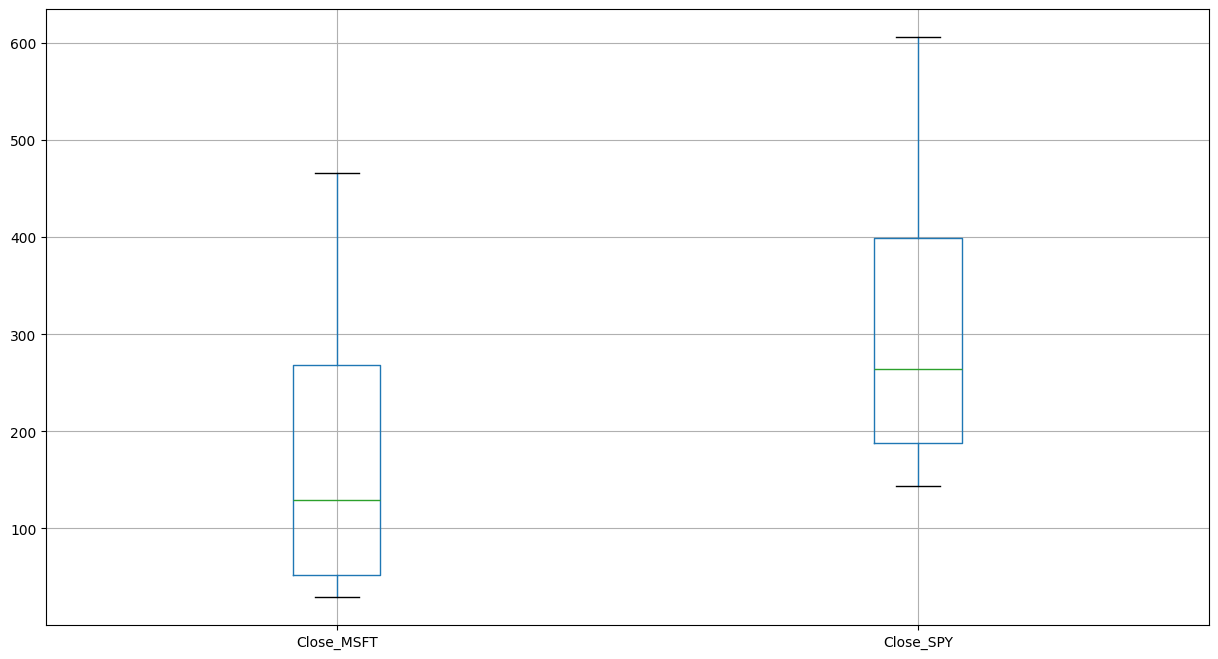

In [25]:
plt.figure(figsize=(15,8))
stock_df_multiple.boxplot()

In [26]:
# 2. Check for missing values
stock_df_multiple.isnull().sum()

,0
Close_MSFT,0
Close_SPY,0


In [27]:
# 3. Find the indexes that are missing
pd.date_range(start = '2014-01-01', end = stock_end_date).difference(stock_df_multiple.index)

DatetimeIndex(['2014-01-01', '2014-01-04', '2014-01-05', '2014-01-11',
               '2014-01-12', '2014-01-18', '2014-01-19', '2014-01-20',
               '2014-01-25', '2014-01-26',
               ...
               '2025-01-01', '2025-01-04', '2025-01-05', '2025-01-09',
               '2025-01-11', '2025-01-12', '2025-01-18', '2025-01-19',
               '2025-01-20', '2025-01-22'],
              dtype='datetime64[ns]', length=1260, freq=None)

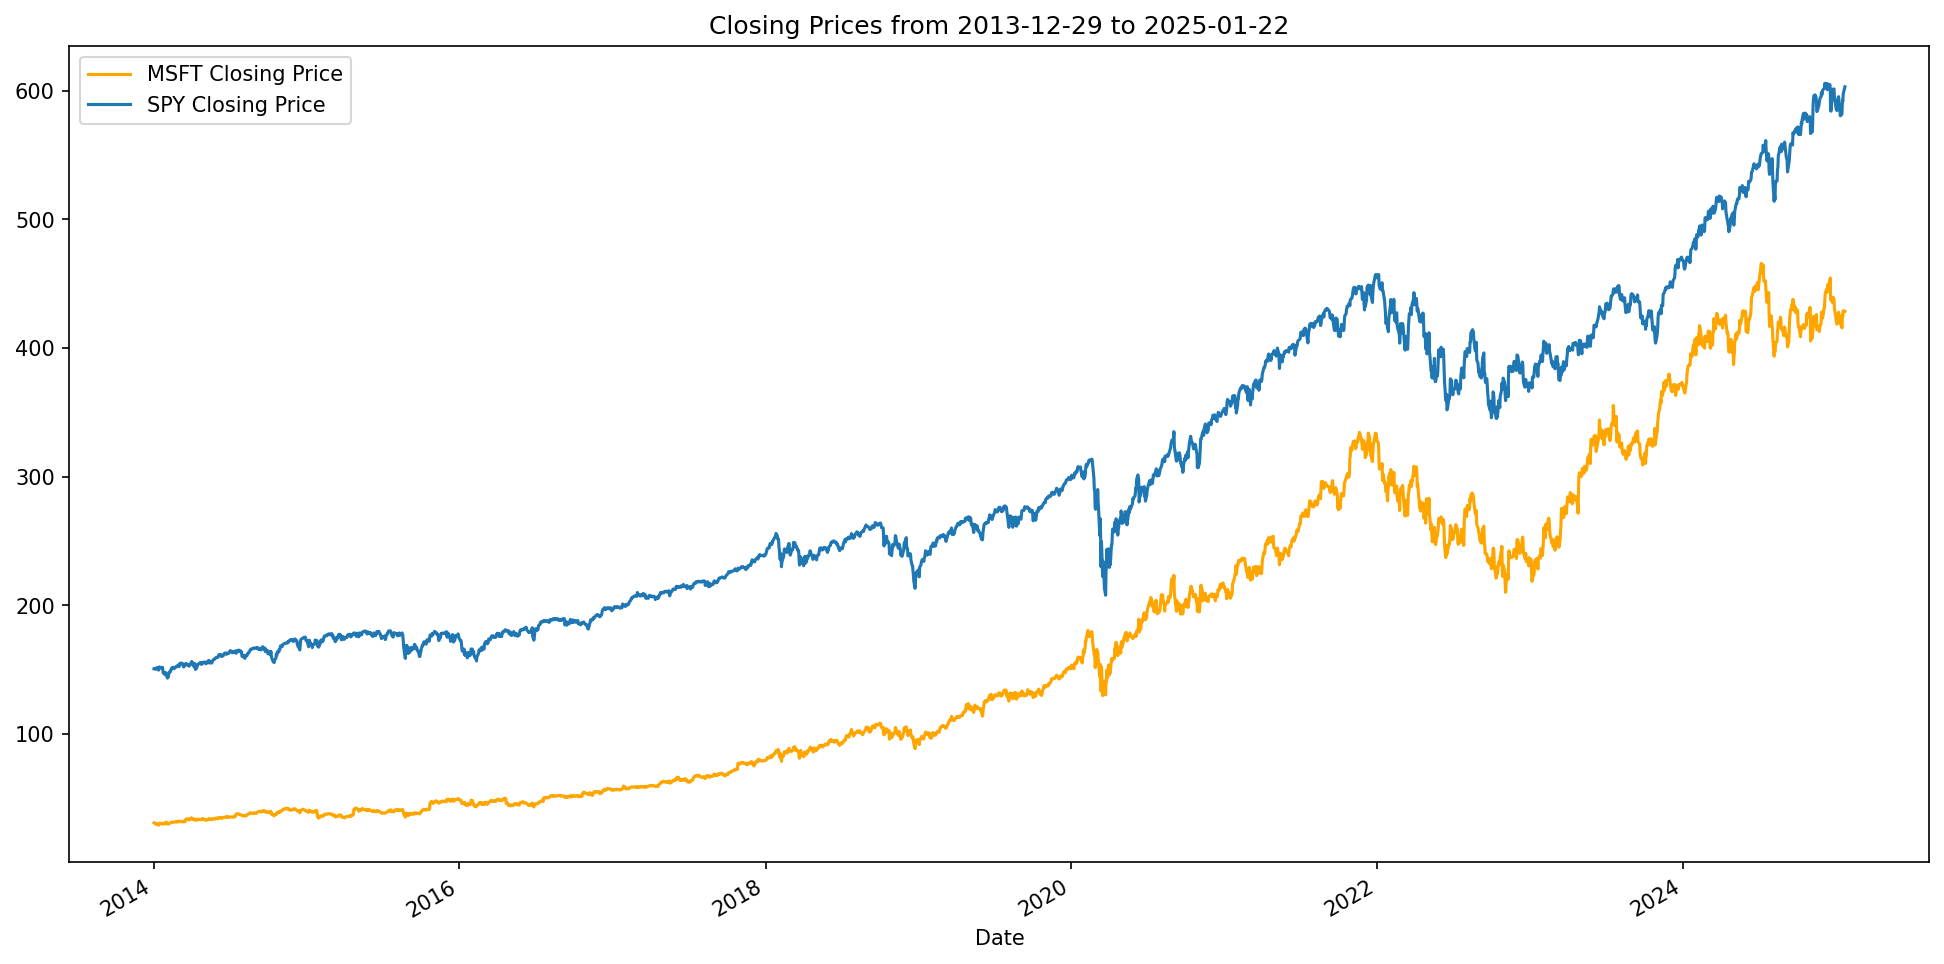

In [28]:
# Visualizing The Close Price of the stocks

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150) #dpi = resolution. default 100.

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
stock_df_multiple['Close_MSFT'].plot(label='MSFT Closing Price', color='orange')
stock_df_multiple['Close_SPY'].plot(label='SPY Closing Price')

# adding title to the plot
plt.title('Closing Prices from {} to {}'.format(stock_start_date, stock_end_date))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


In [29]:
# 4. Let's complete the broken time series indexes and interpolate (impute missing values) the data

# SEE SLIDES

**Impute Missing Values**

Some time series models work with complete data, and therefore they require the missing data to be replaced with meaningful values before actual analysis. At a high level, missing values in time series are handled in two ways, either dropping them or replacing them. However, dropping missing values can be an inappropriate solution due to the time order of the data and the correlation between observations in adjacent periods.

Estimating a reasonable value such that the components of the series are not distorted is an excellent approach to dealing with missing values in time series. Imputation replaces missing values with values estimated from the same data or observed from the environment with the same conditions underlying the missing data.

Different ways to impute the missing values are as follows.
1. Mean or Median imputation
2. Last Observation Carried Forward (LOCF) or forward fill - the missing value is imputed using the values before it in the time series
3. Next Observation Carried Backward (NOCB) or back fill- the missing values are imputed using an immediate value ahead of them
4. Linear interpolation - estimates unknown values by assuming linear relation within a range of data points
5. Spline interpolation - estimates values that minimize overall curvature, thus obtaining a smooth surface passing through the input points


In [30]:
stock_df_multiple

,Close_MSFT,Close_SPY
Date,,
2014-01-02,31.058577,150.735611
2014-01-03,30.849609,150.710861
2014-01-06,30.197685,150.274185
2014-01-07,30.431705,151.197098
2014-01-08,29.888435,151.230042
...,...,...
2025-01-14,415.670013,582.190002
2025-01-15,426.309998,592.780029
2025-01-16,424.579987,591.640015


In [31]:
# first, fill the misssing values with 'NaN'. Reindexing.
stock_df_multiple_NaN = stock_df_multiple.reindex(pd.date_range('2014-01-01', stock_end_date), fill_value= np.NaN)
stock_df_multiple_NaN

,Close_MSFT,Close_SPY
2014-01-01,NaN,NaN
2014-01-02,31.058577,150.735611
2014-01-03,30.849609,150.710861
2014-01-04,NaN,NaN
2014-01-05,NaN,NaN
...,...,...
2025-01-18,NaN,NaN
2025-01-19,NaN,NaN
2025-01-20,NaN,NaN
2025-01-21,428.500000,603.049988


In [32]:
# next, let's use ALL the different imputation techniques on MSFT and just the spline on SPY

stock_df_multiple_imputed = stock_df_multiple_NaN.copy()
stock_df_multiple_imputed['MSFT_Spline']= stock_df_multiple_imputed['Close_MSFT'].interpolate(method='spline', order=1, limit=10, limit_direction='both')
stock_df_multiple_imputed['MSFT_Linear']= stock_df_multiple_imputed['Close_MSFT'].interpolate(method='linear', order=1, limit=10, limit_direction='both')
stock_df_multiple_imputed['MSFT_ffill']= stock_df_multiple_imputed['Close_MSFT'].fillna(method ='ffill')
stock_df_multiple_imputed['MSFT_bfill']= stock_df_multiple_imputed['Close_MSFT'].fillna(method ='bfill')
stock_df_multiple_imputed['MSFT_Mean']= stock_df_multiple_imputed['Close_MSFT'].fillna(stock_df_multiple_imputed['Close_MSFT'].mean())
stock_df_multiple_imputed['MSFT_Median']= stock_df_multiple_imputed['Close_MSFT'].fillna(stock_df_multiple_imputed['Close_MSFT'].median())
stock_df_multiple_imputed['SPY_Spline']= stock_df_multiple_imputed['Close_SPY'].interpolate(method='spline', order=1, limit=10, limit_direction='both')

stock_df_multiple_imputed.round(2)


<ipython-input-32-5d1b5f24ddd9>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_df_multiple_imputed['MSFT_ffill']= stock_df_multiple_imputed['Close_MSFT'].fillna(method ='ffill')
<ipython-input-32-5d1b5f24ddd9>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_df_multiple_imputed['MSFT_bfill']= stock_df_multiple_imputed['Close_MSFT'].fillna(method ='bfill')


,Close_MSFT,Close_SPY,MSFT_Spline,MSFT_Linear,MSFT_ffill,MSFT_bfill,MSFT_Mean,MSFT_Median,SPY_Spline
2014-01-01,NaN,NaN,29.77,31.06,NaN,31.06,169.81,129.27,150.51
2014-01-02,31.06,150.74,31.06,31.06,31.06,31.06,31.06,31.06,150.74
2014-01-03,30.85,150.71,30.85,30.85,30.85,30.85,30.85,30.85,150.71
2014-01-04,NaN,NaN,29.87,30.63,30.85,30.20,169.81,129.27,150.74
2014-01-05,NaN,NaN,29.91,30.41,30.85,30.20,169.81,129.27,150.81
...,...,...,...,...,...,...,...,...,...
2025-01-18,NaN,NaN,427.44,428.90,429.03,428.50,169.81,129.27,597.52
2025-01-19,NaN,NaN,427.93,428.76,429.03,428.50,169.81,129.27,599.50
2025-01-20,NaN,NaN,428.43,428.63,429.03,428.50,169.81,129.27,601.48
2025-01-21,428.50,603.05,428.50,428.50,428.50,428.50,428.50,428.50,603.05


In [33]:
# which imputation technique doesnt make sense and why?

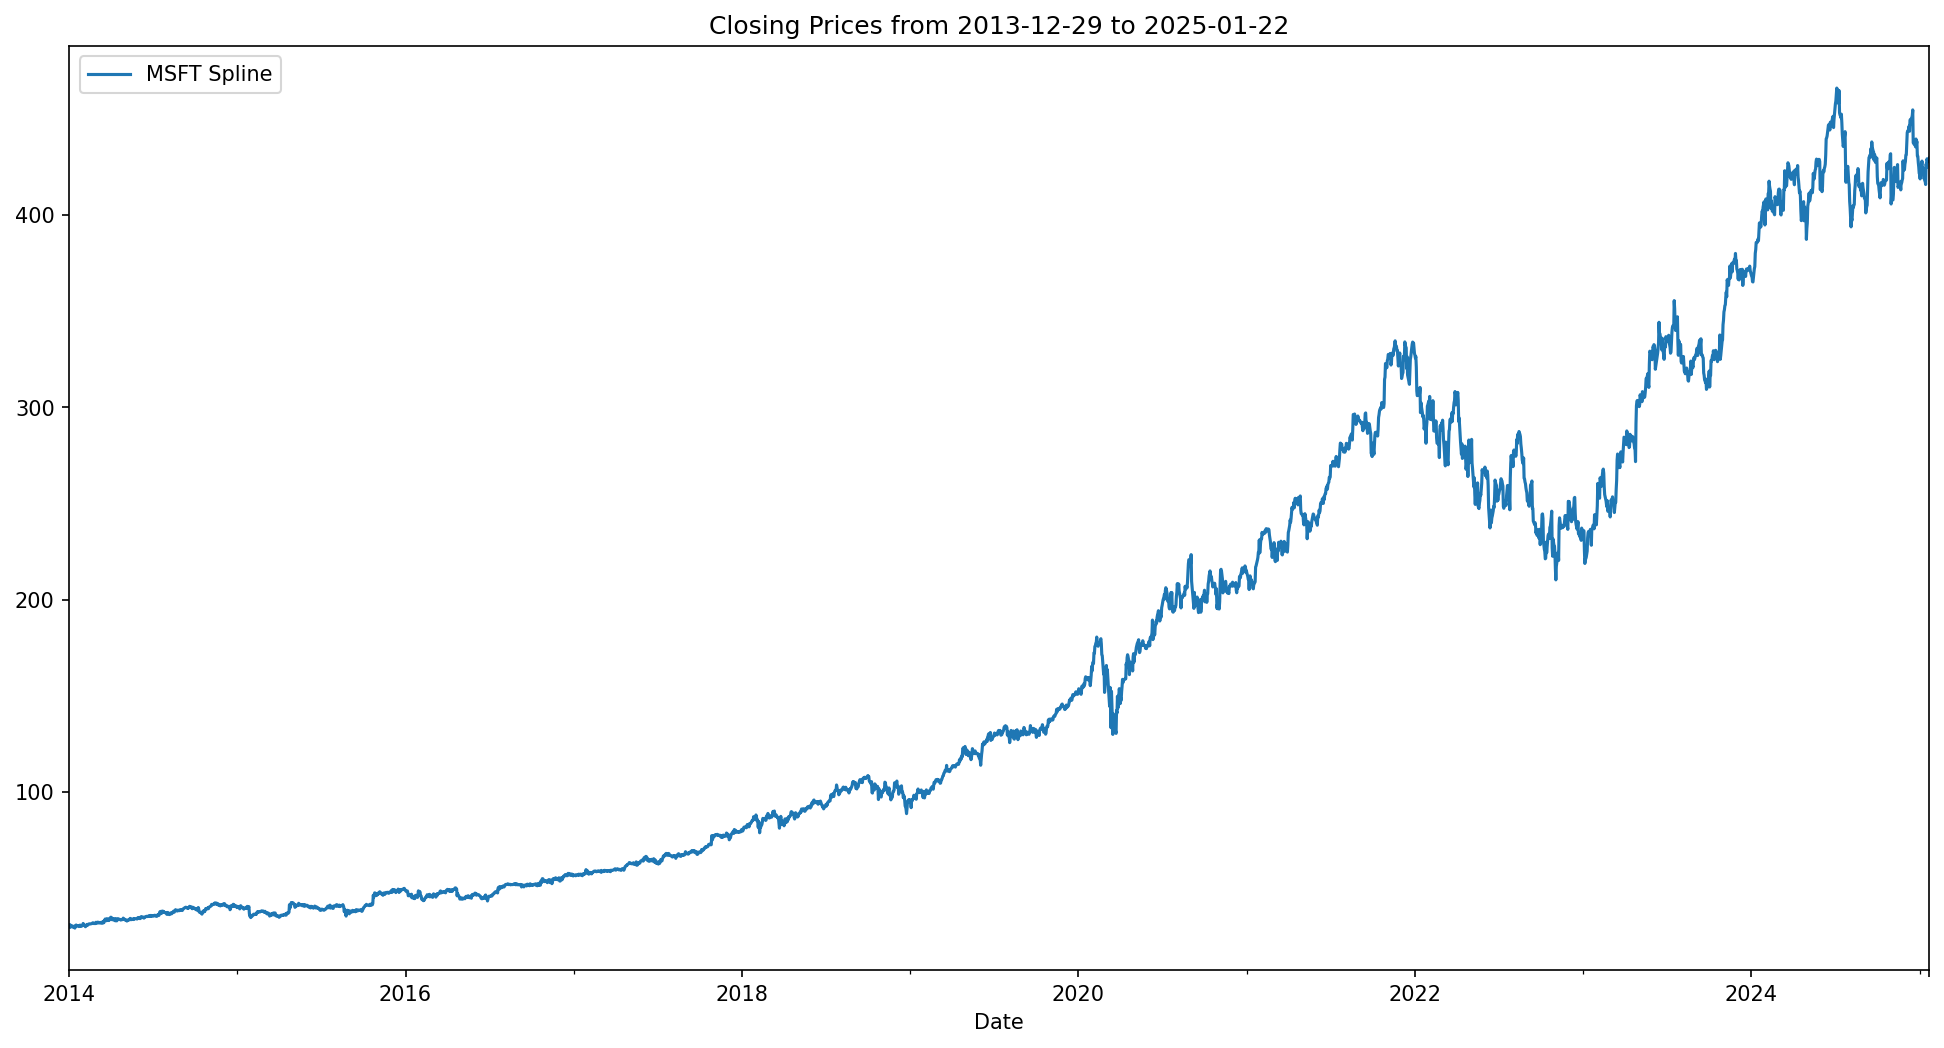

In [34]:
#Plot

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
#stock_df_multiple_imputed['MSFT_Median'].plot(label='MSFT Median', color='orange')
#stock_df_multiple_imputed['MSFT_Linear'].plot(label='MSFT Linear')
#stock_df_multiple_imputed['MSFT_bfill'].plot(label='MSFT Backfill')
stock_df_multiple_imputed['MSFT_Spline'].plot(label='MSFT Spline')


# adding title to the plot
plt.title('Closing Prices from {} to {}'.format(stock_start_date, stock_end_date))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


In [35]:
# 5. Time Series Visualizations - Box and Whisker Plots - Outlier Detection
# Source: https://towardsdatascience.com/plotting-time-series-boxplots-5a21f2b76cfe

# ask students - why is outlier detection important?

Brief overview of Outlier Detection techniques can be found here: https://cnvrg.io/anomaly-detection-python/

1. Distribution-based techniques – Minimum Covariance Determinant, Elliptic Envelope
2. Depth-based technique – Isolation Forest
3. Clustering-based technique – Local Outlier Factor
4. Density-based technique – DBSCAN
5. Unified library for Outlier Detection – PyOD
6. Statistical techniques – Interquartile range
7. Visualization techniques – Box-plot

<Axes: xlabel='None', ylabel='SPY_Spline'>

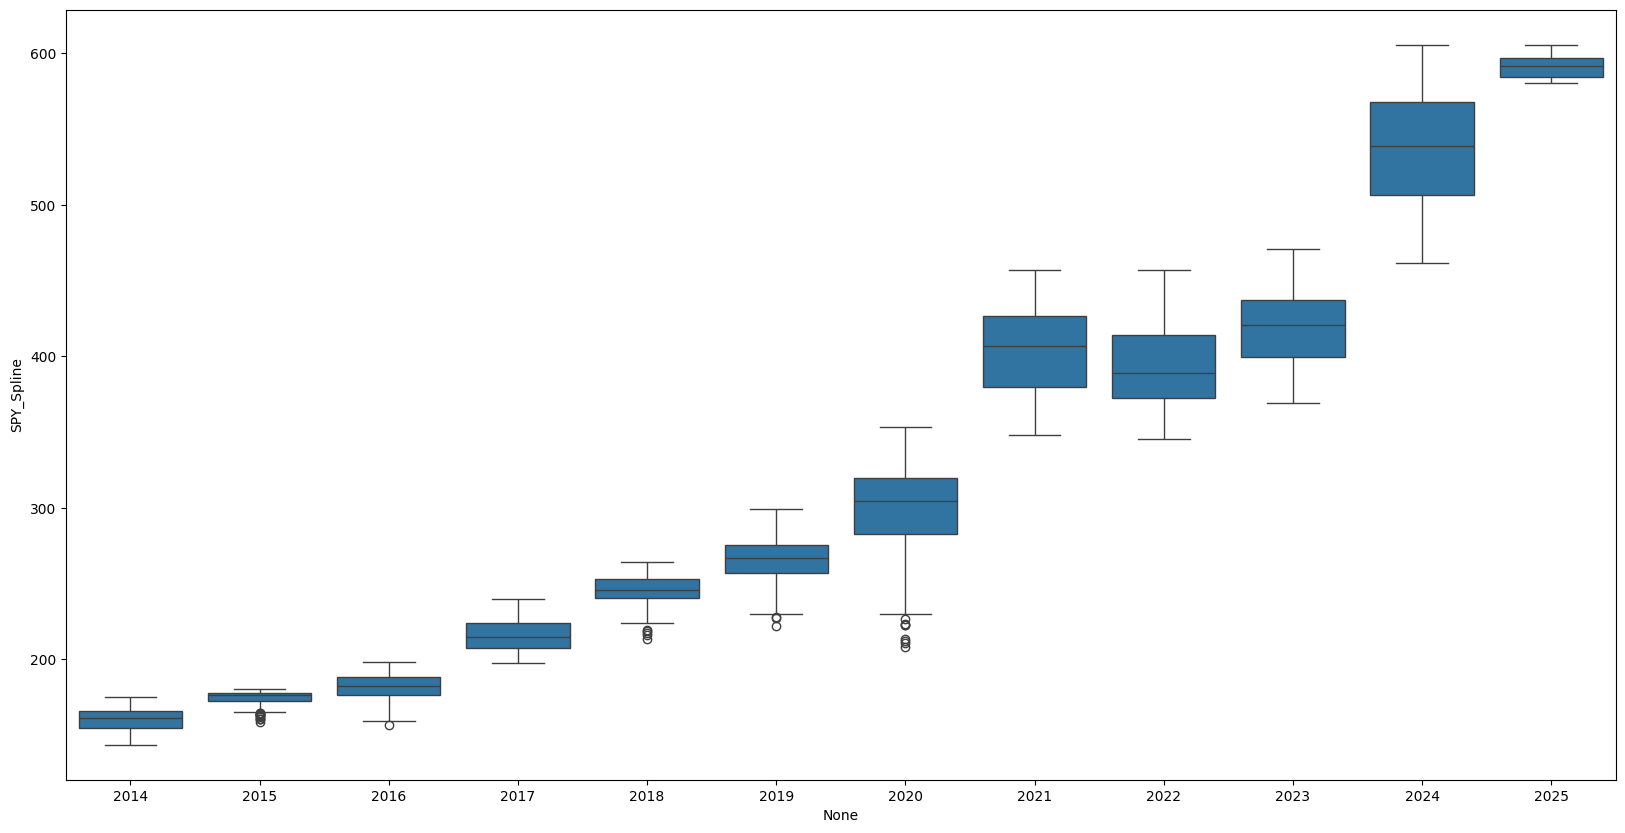

In [36]:
# price variation for each year

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = stock_df_multiple_imputed.index.year,
                y = stock_df_multiple_imputed['SPY_Spline'],
                ax = ax)

<Axes: xlabel='None', ylabel='SPY_Spline'>

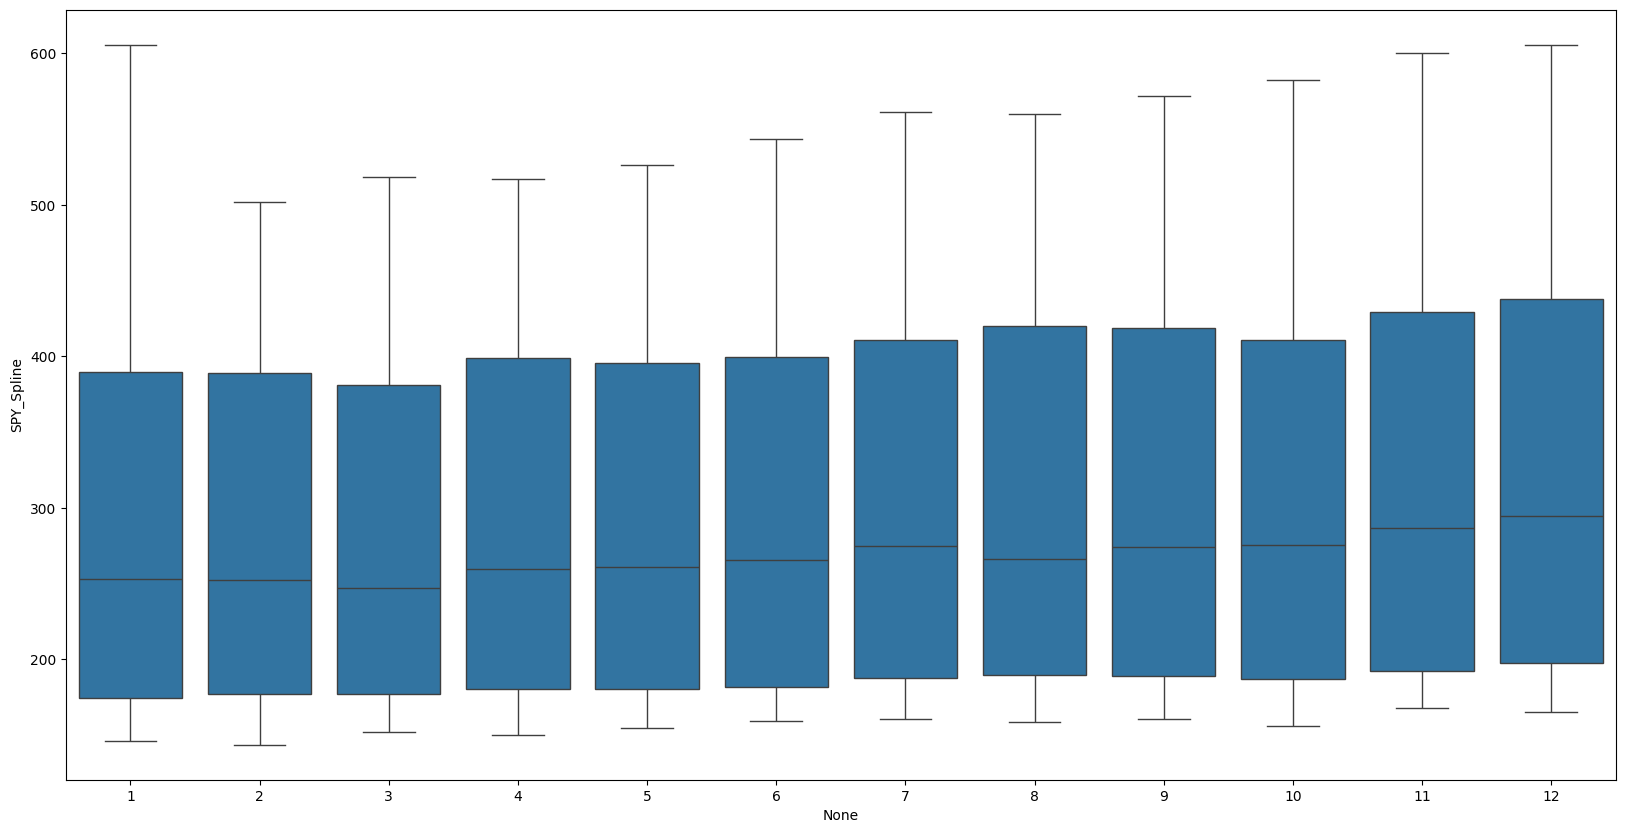

In [37]:
# price variation for each month

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = stock_df_multiple_imputed.index.month,
                y = stock_df_multiple_imputed['SPY_Spline'],
                ax = ax)

In [38]:
# 6. Resampling

Resampling involves changing the frequency of your time series observations. Two types of
resampling are:
1. Upsampling: Where you increase the frequency of the samples, such as from minutes to seconds.
2. Downsampling: Where you decrease the frequency of the samples, such as from days to months.

In both cases, data must be invented. In the case of upsampling, care may be needed in
determining how the fine-grained observations are calculated using interpolation. In the case of
downsampling, care may be needed in selecting the summary statistics used to calculate the
new aggregated values.

There are perhaps two main reasons why you may be interested in resampling your time
series data:
1. Problem Framing: Resampling may be required if your data is not available at the same frequency that you want to make predictions.
2. Feature Engineering: Resampling can also be used to provide additional structure or insight into the learning problem for supervised learning models.

There is a lot of overlap between these two cases. For example, you may have daily data
and want to predict a monthly problem. You could use the daily data directly or you could
downsample it to monthly data and develop your model. A feature engineering perspective may
use observations and summaries of observations from both time scales and more in developing a
model.

In [39]:
df_resample = stock_df_multiple_imputed.copy()

# extract only the spline variables
df_resample = df_resample[['MSFT_Spline', 'SPY_Spline']].round(2)
df_resample

,MSFT_Spline,SPY_Spline
2014-01-01,29.77,150.51
2014-01-02,31.06,150.74
2014-01-03,30.85,150.71
2014-01-04,29.87,150.74
2014-01-05,29.91,150.81
...,...,...
2025-01-18,427.44,597.52
2025-01-19,427.93,599.50
2025-01-20,428.43,601.48
2025-01-21,428.50,603.05


In [40]:
# downsample the data from days to months to reduce variability in the data
# observe the stock prices on a monthly basis

df_resample_months = df_resample.groupby(pd.Grouper(freq='MS')).median()
#df_resample_months = df_resample.resample('M').median() #another way of resampling
df_resample_months

,MSFT_Spline,SPY_Spline
2014-01-01,30.310,150.810
2014-02-01,31.405,150.895
2014-03-01,32.580,154.120
2014-04-01,33.775,154.365
2014-05-01,33.780,156.480
...,...,...
2024-09-01,428.740,558.550
2024-10-01,417.320,577.700
2024-11-01,417.545,593.560
2024-12-01,437.420,601.340


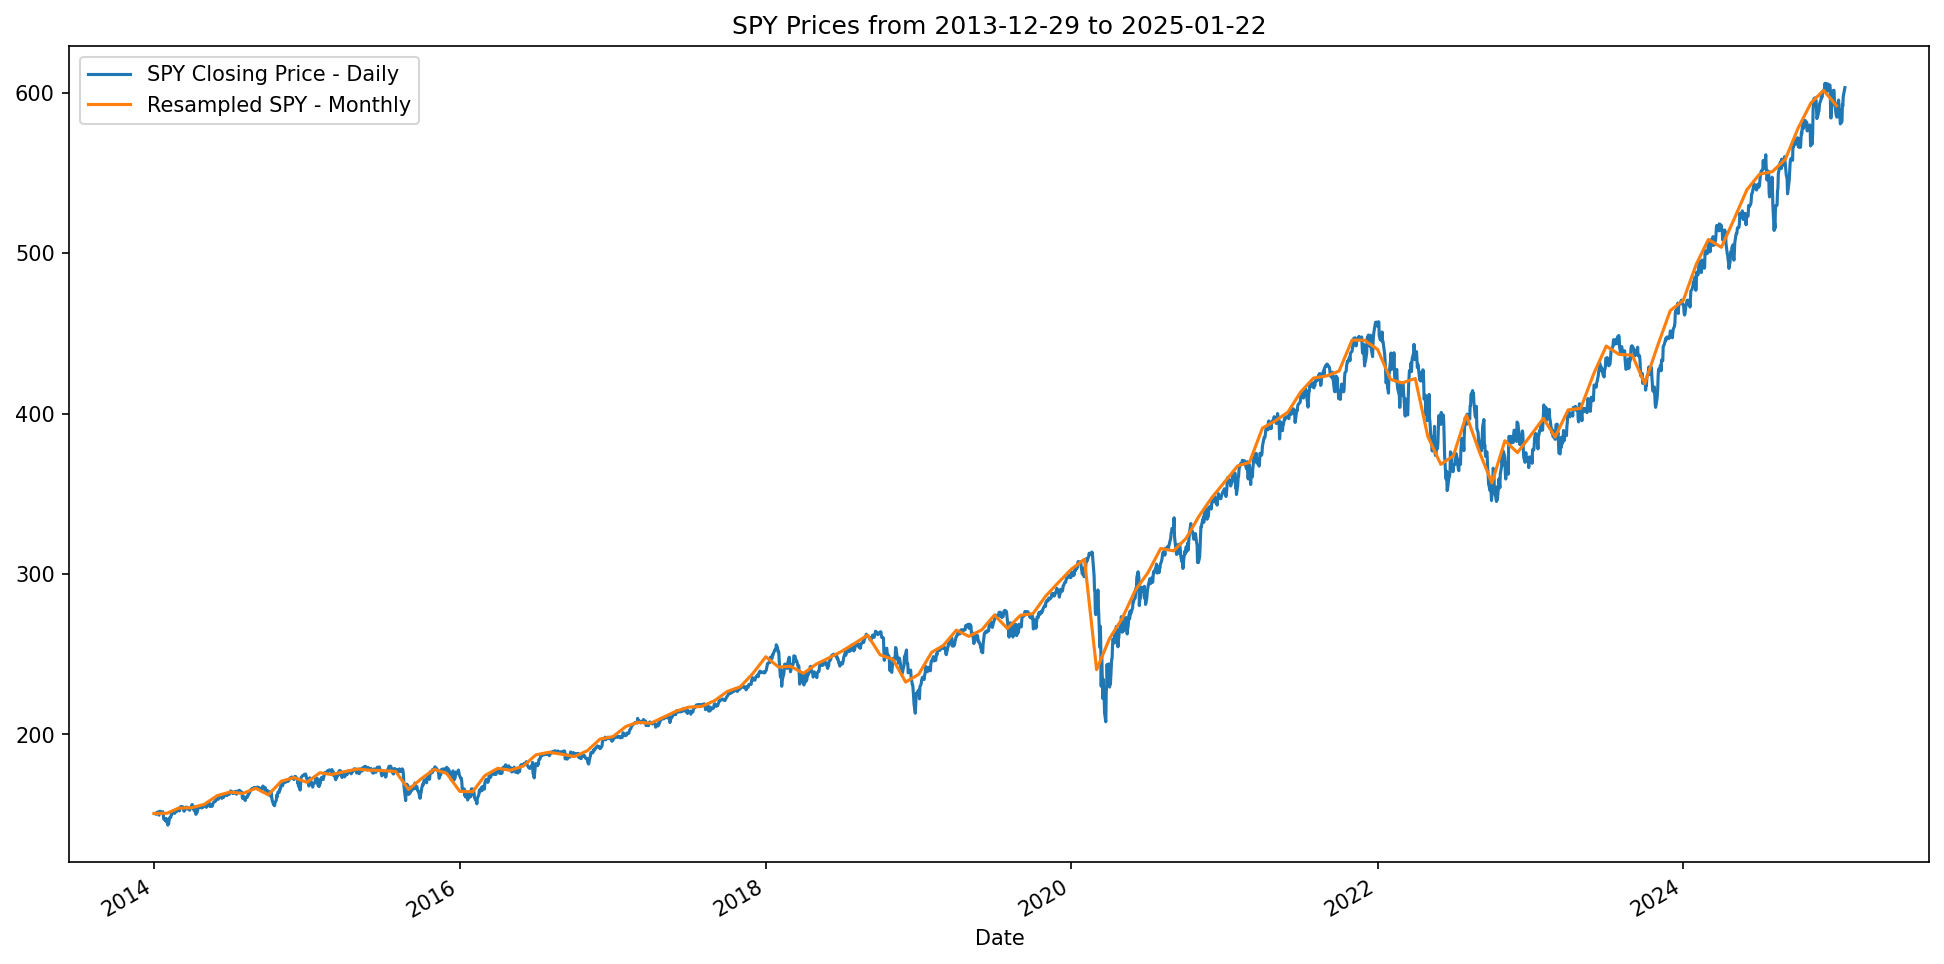

In [41]:
#Plot monthly data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
#df_resample_months['MSFT_Spline'].plot(label='MSFT')
stock_df_multiple['Close_SPY'].plot(label='SPY Closing Price - Daily')
df_resample_months['SPY_Spline'].plot(label='Resampled SPY - Monthly')


# adding title to the plot
plt.title('SPY Prices from {} to {}'.format(stock_start_date, stock_end_date))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()

In [42]:
# 6. Autocorrelation or ACF plot


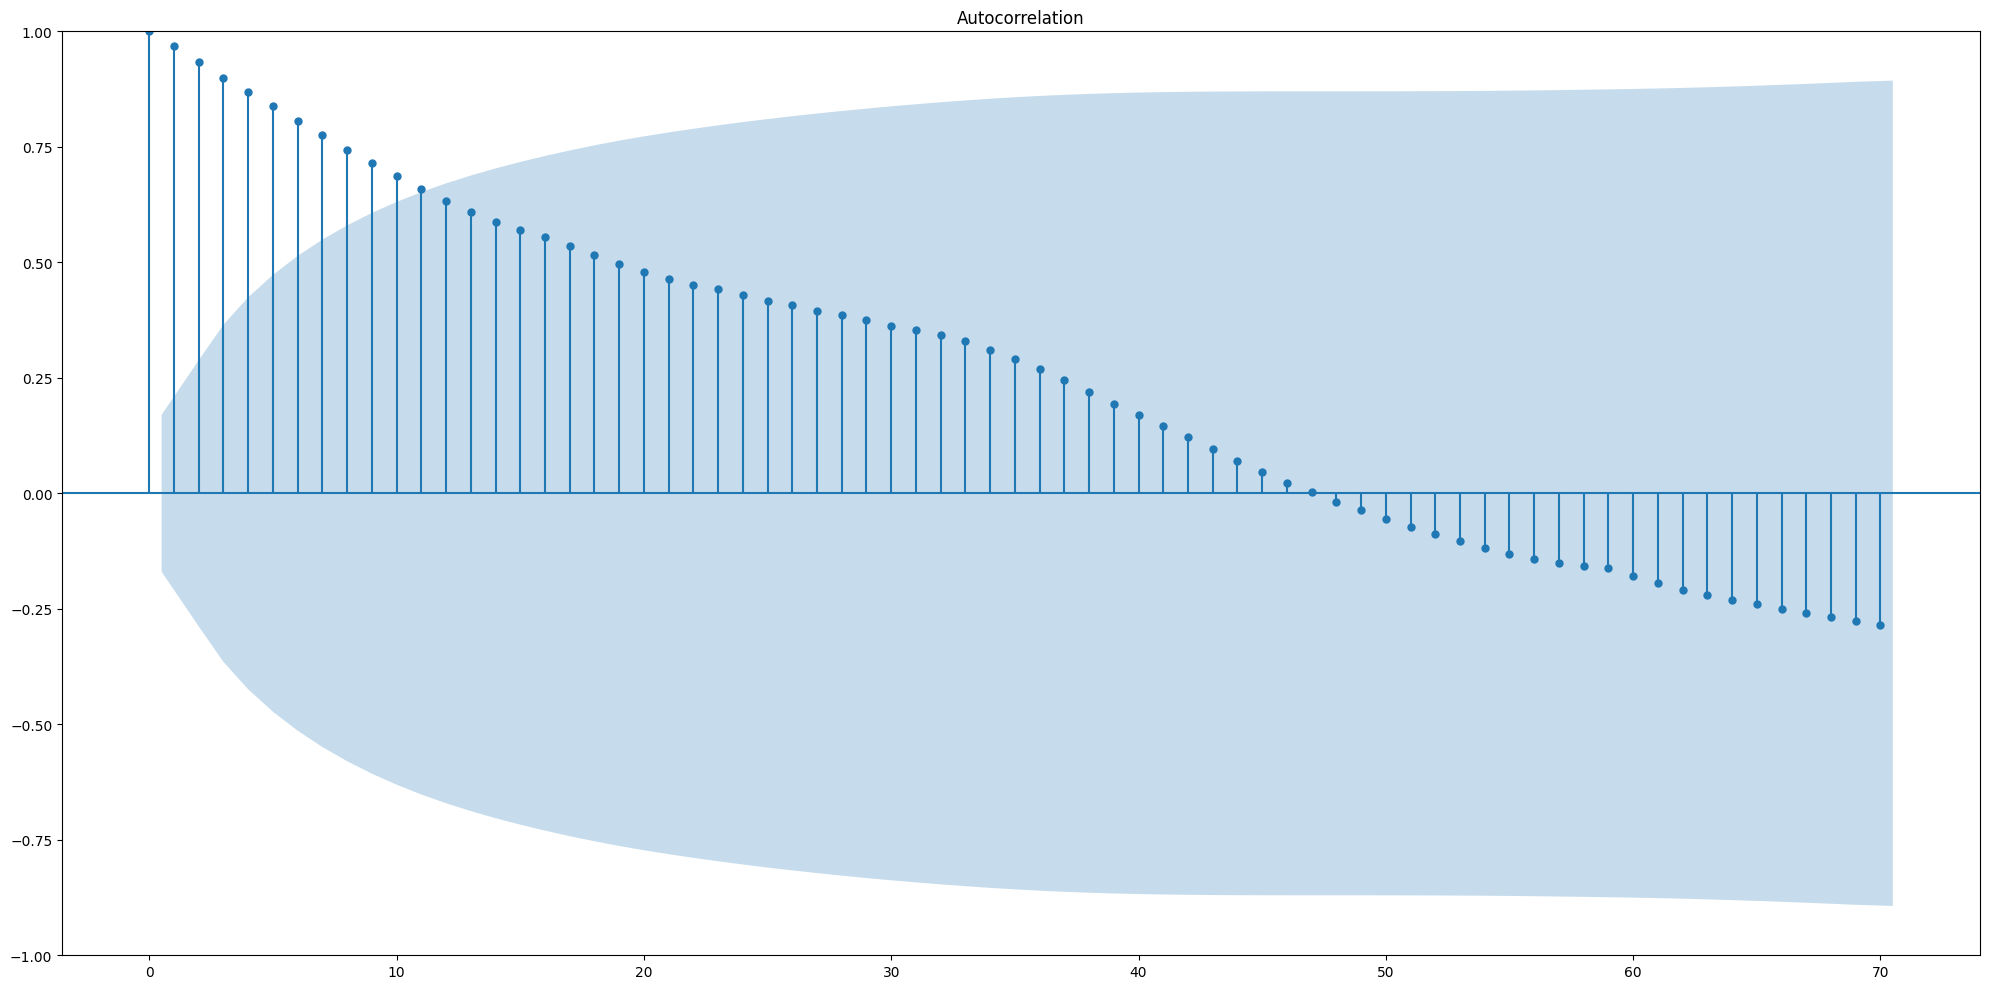

In [43]:
# Calculate the ACF (via statsmodel)
# Source: https://www.alpharithms.com/autocorrelation-time-series-python-432909/

fig = plot_acf(df_resample_months['SPY_Spline'], lags=70)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [44]:
# 7. Time Series Decomposition
# Source: https://stackoverflow.com/questions/20672236/time-series-decomposition-function-in-python

Time series decomposition is a process of deconstructing a time series into the following components:

1. Trend — general movement over time
2. Seasonal — behaviors captured in individual seasonal periods
3. Residual — everything not captured by trend and seasonal components


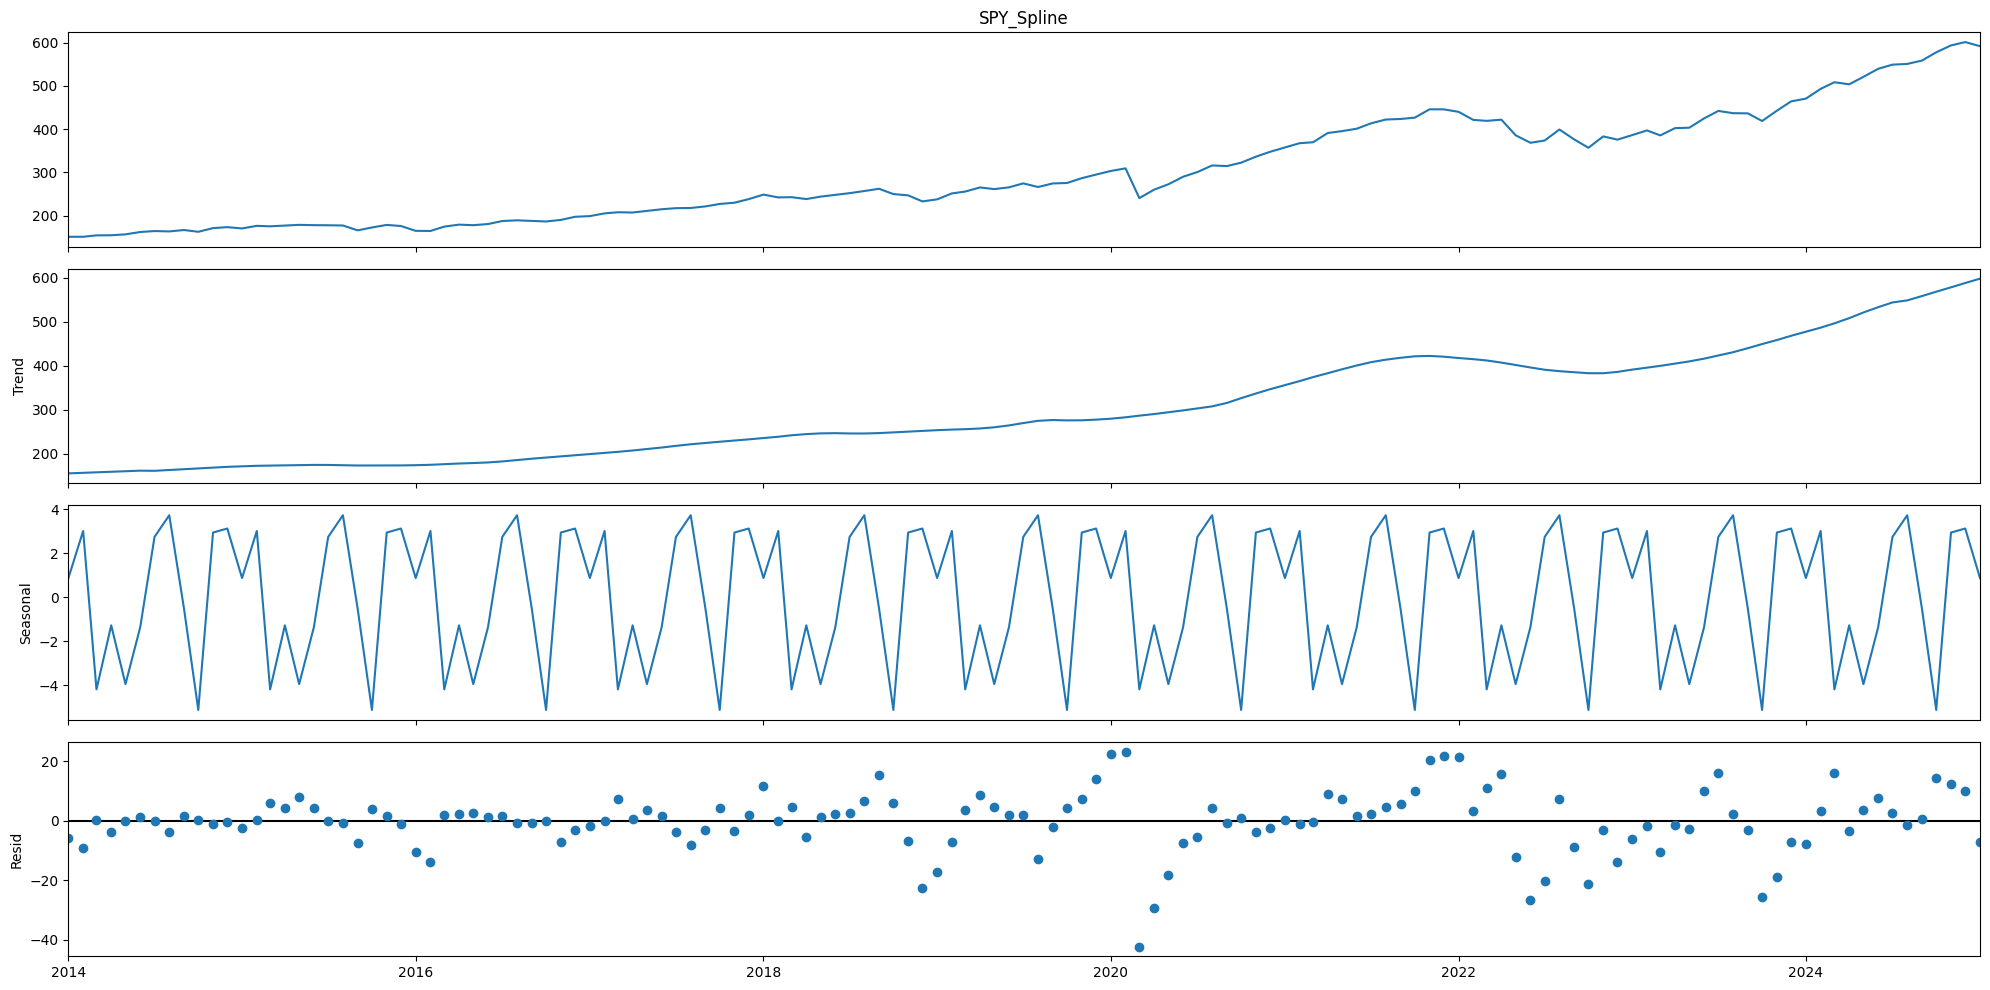

In [45]:
res = sm.tsa.seasonal_decompose(df_resample_months['SPY_Spline'], period=12, extrapolate_trend='freq')
fig = res.plot()
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [46]:
# We can extract the trend, seasonality, and error terms
# going forward let us only concentrate on one time series - SPY

In [47]:
spy_df = df_resample_months[['SPY_Spline']]

# extract the decomposed terms
spy_df['trend'] = res.trend
spy_df['seasonal'] = res.seasonal
spy_df['error'] = res.resid
spy_df

,SPY_Spline,trend,seasonal,error
2014-01-01,150.810,155.710049,0.872025,-5.772074
2014-02-01,150.895,156.941396,3.009211,-9.055607
2014-03-01,154.120,158.172743,-4.185192,0.132449
2014-04-01,154.365,159.404090,-1.276299,-3.762790
2014-05-01,156.480,160.635437,-3.946895,-0.208541
...,...,...,...,...
2024-09-01,558.550,558.490327,-0.519670,0.579342
2024-10-01,577.700,568.370541,-5.120484,14.449943
2024-11-01,593.560,578.250756,2.938549,12.370695
2024-12-01,601.340,588.130970,3.121863,10.087167


In [48]:
155.710049+0.872025-5.772074

150.81

<Axes: >

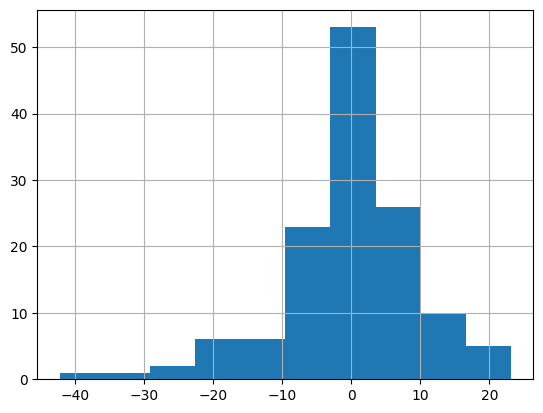

In [49]:
spy_df['error'].hist()

In [50]:
# 8 . Time Series Viz - pairplot
# Source: https://seaborn.pydata.org/generated/seaborn.pairplot.html

In [51]:
df_resample_months

,MSFT_Spline,SPY_Spline
2014-01-01,30.310,150.810
2014-02-01,31.405,150.895
2014-03-01,32.580,154.120
2014-04-01,33.775,154.365
2014-05-01,33.780,156.480
...,...,...
2024-09-01,428.740,558.550
2024-10-01,417.320,577.700
2024-11-01,417.545,593.560
2024-12-01,437.420,601.340


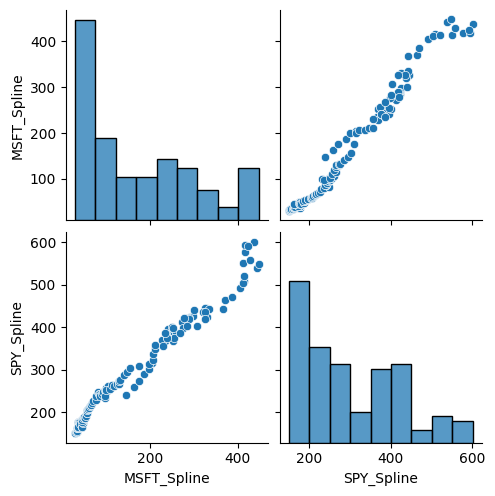

In [52]:
sns.pairplot(df_resample_months)


In [53]:
np.corrcoef(df_resample_months['MSFT_Spline'],df_resample_months['SPY_Spline'])

array([[1.        , 0.98886281],
       [0.98886281, 1.        ]])

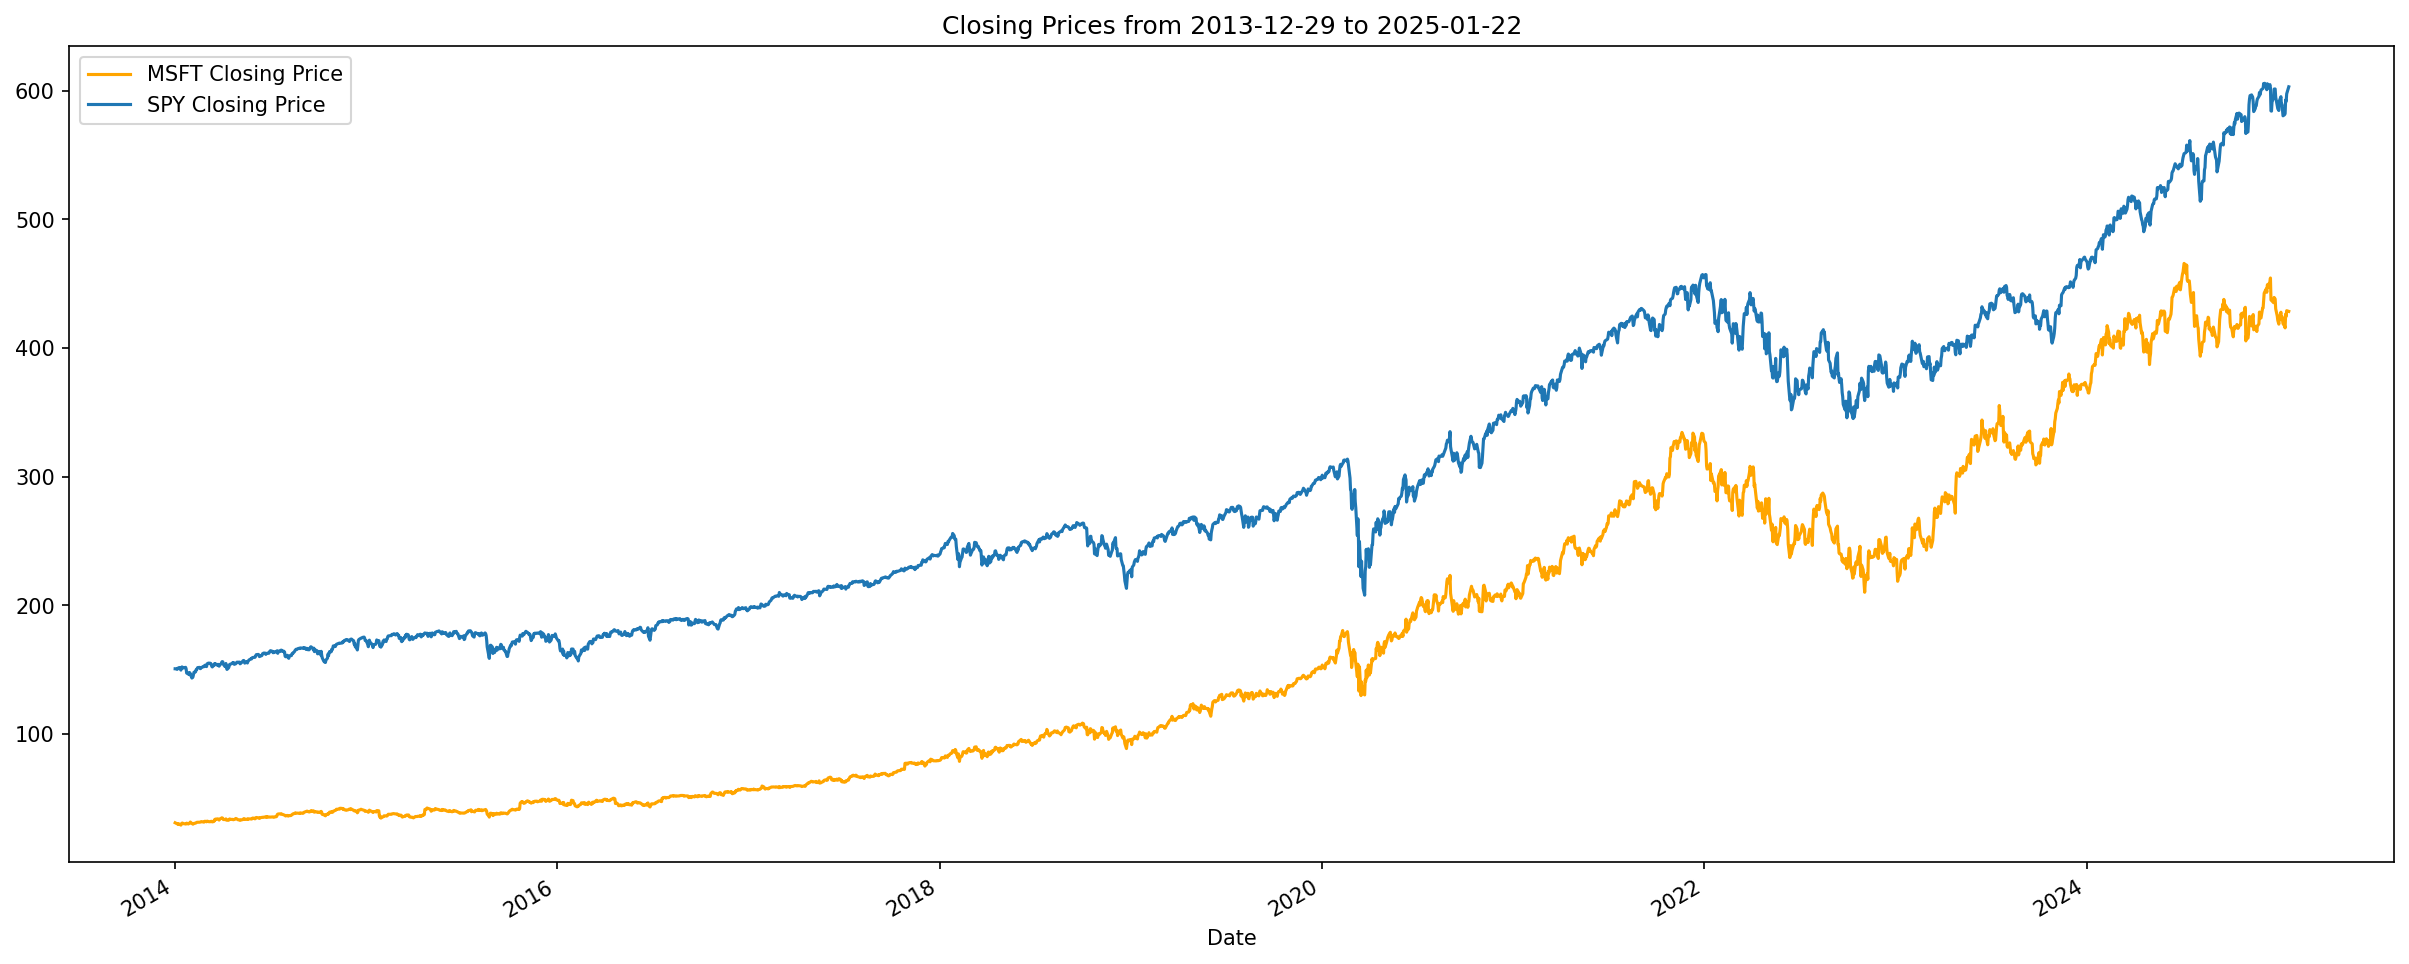

In [54]:
# Visualizing The Close Price of the stocks

# to set the plot size
plt.figure(figsize=(20, 8), dpi=150) #dpi = resolution. default 100.

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
stock_df_multiple['Close_MSFT'].plot(label='MSFT Closing Price', color='orange')
stock_df_multiple['Close_SPY'].plot(label='SPY Closing Price')

# adding title to the plot
plt.title('Closing Prices from {} to {}'.format(stock_start_date, stock_end_date))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


In [55]:
df_resample_months

,MSFT_Spline,SPY_Spline
2014-01-01,30.310,150.810
2014-02-01,31.405,150.895
2014-03-01,32.580,154.120
2014-04-01,33.775,154.365
2014-05-01,33.780,156.480
...,...,...
2024-09-01,428.740,558.550
2024-10-01,417.320,577.700
2024-11-01,417.545,593.560
2024-12-01,437.420,601.340


In [56]:
# spurious correlation - https://www.statology.org/spurious-correlation-examples/

In [57]:
#lets understand spurious correlation using two white noise series.
#The two series should not be correlated with each other

In [58]:
# generate two white noise series with 1000 samples each
# set random seed for reproducibility
np.random.seed(42)

wn1 = np.random.normal(size=1000)
wn2 = np.random.normal(size=1000)

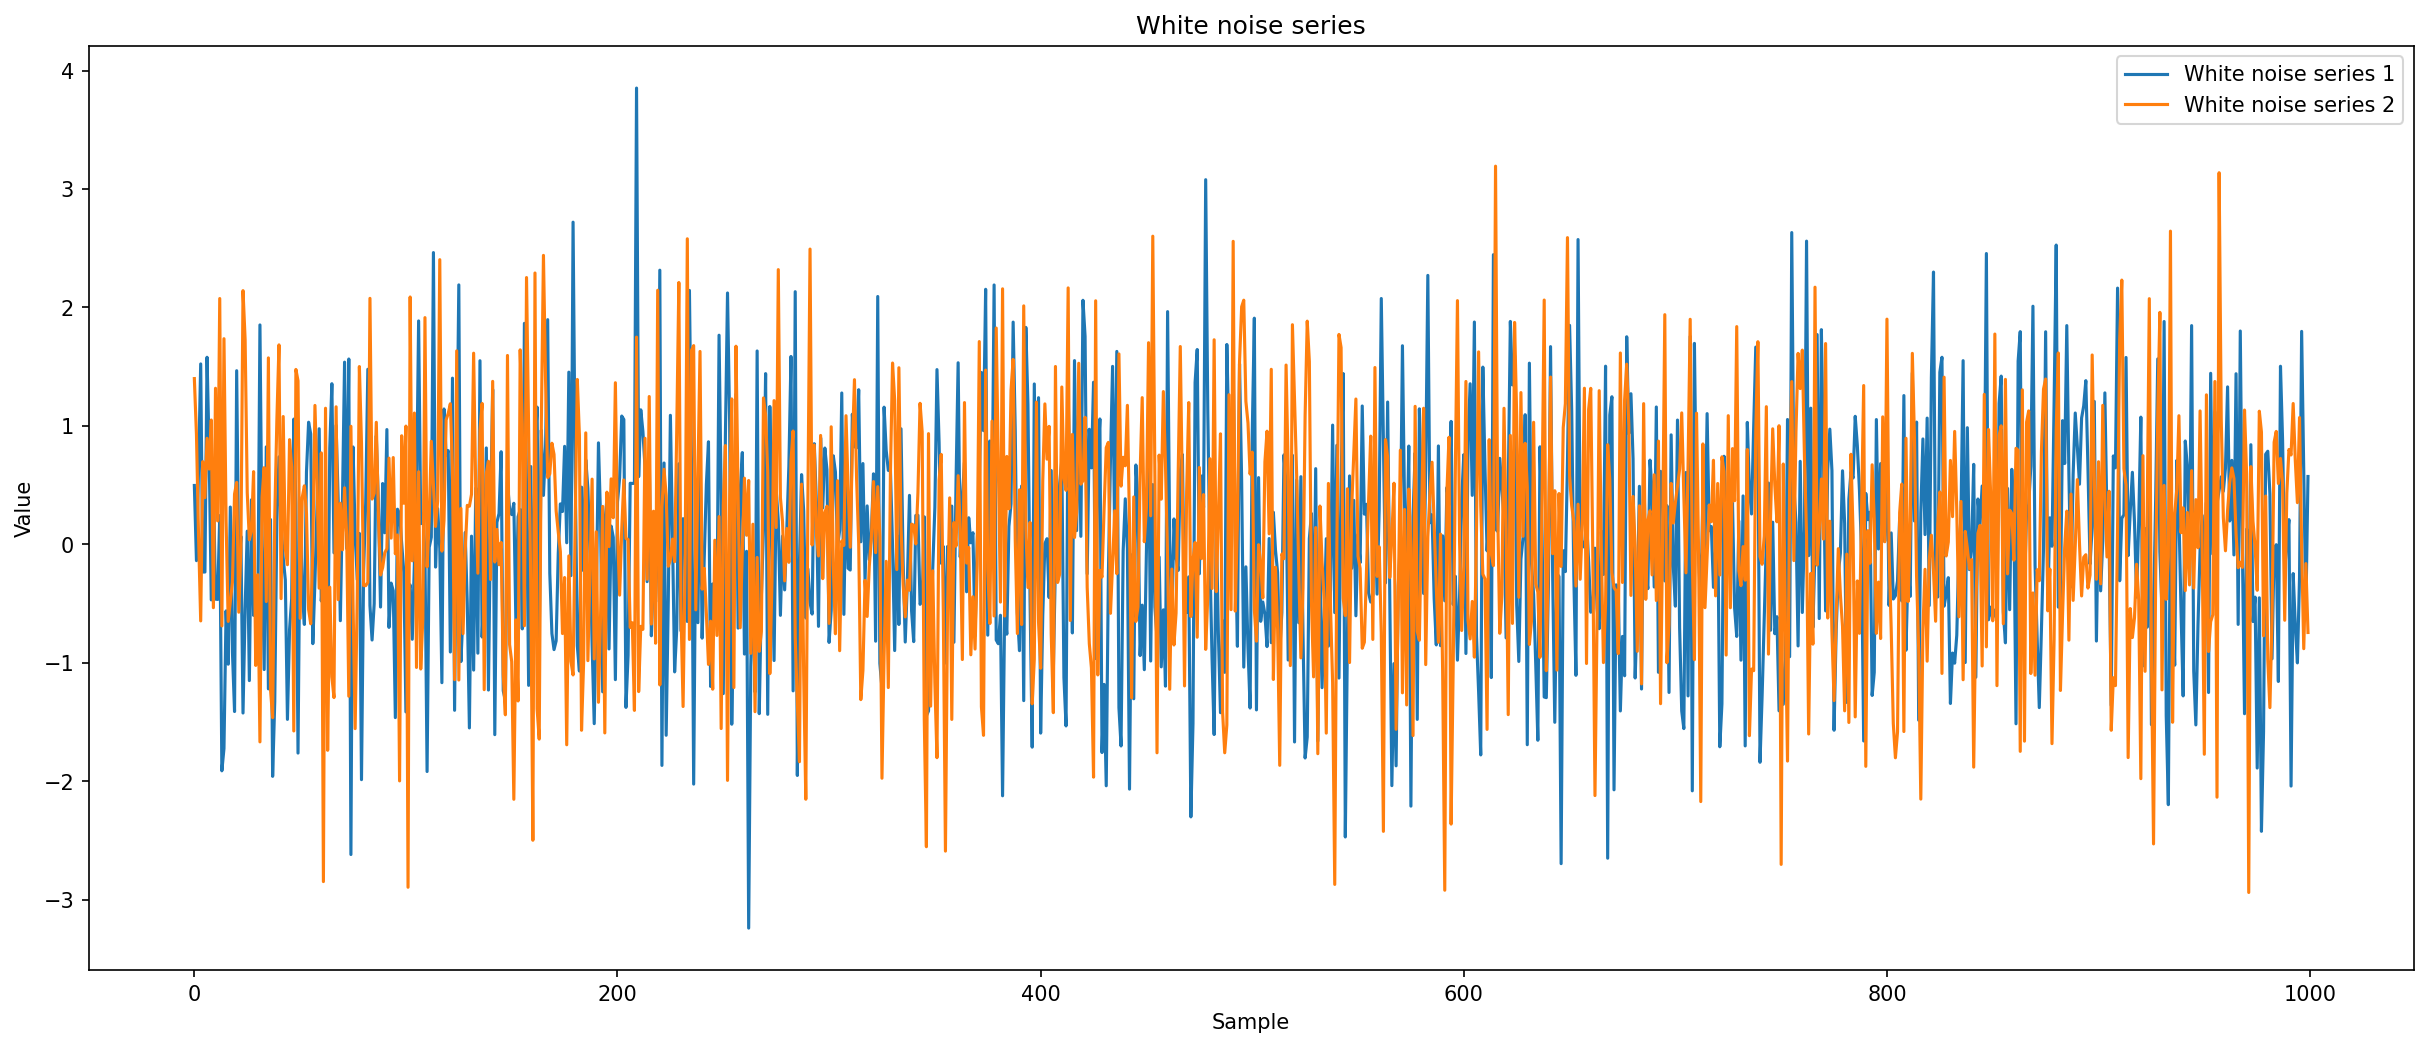

In [59]:
plt.figure(figsize=(20, 8), dpi=150)

# plot the two white noise series
plt.plot(wn1, label='White noise series 1')
plt.plot(wn2, label='White noise series 2')

# add legend and axis labels
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('White noise series')

# show the plot
plt.show()

In [60]:
# calculate correlation between the two white noise series
corr1 = np.corrcoef(wn1, wn2)[0, 1]
print("Correlation between white noise series: {:.3f}".format(corr1))

Correlation between white noise series: -0.040


In [61]:
# Now, add a linear trend to both white noise series
trend = np.linspace(0, 10, 1000)
wn1_trend = wn1 + trend
wn2_trend = wn2 + trend

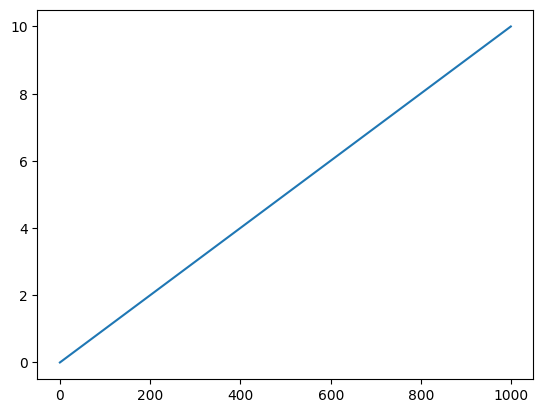

In [62]:
plt.plot(trend)

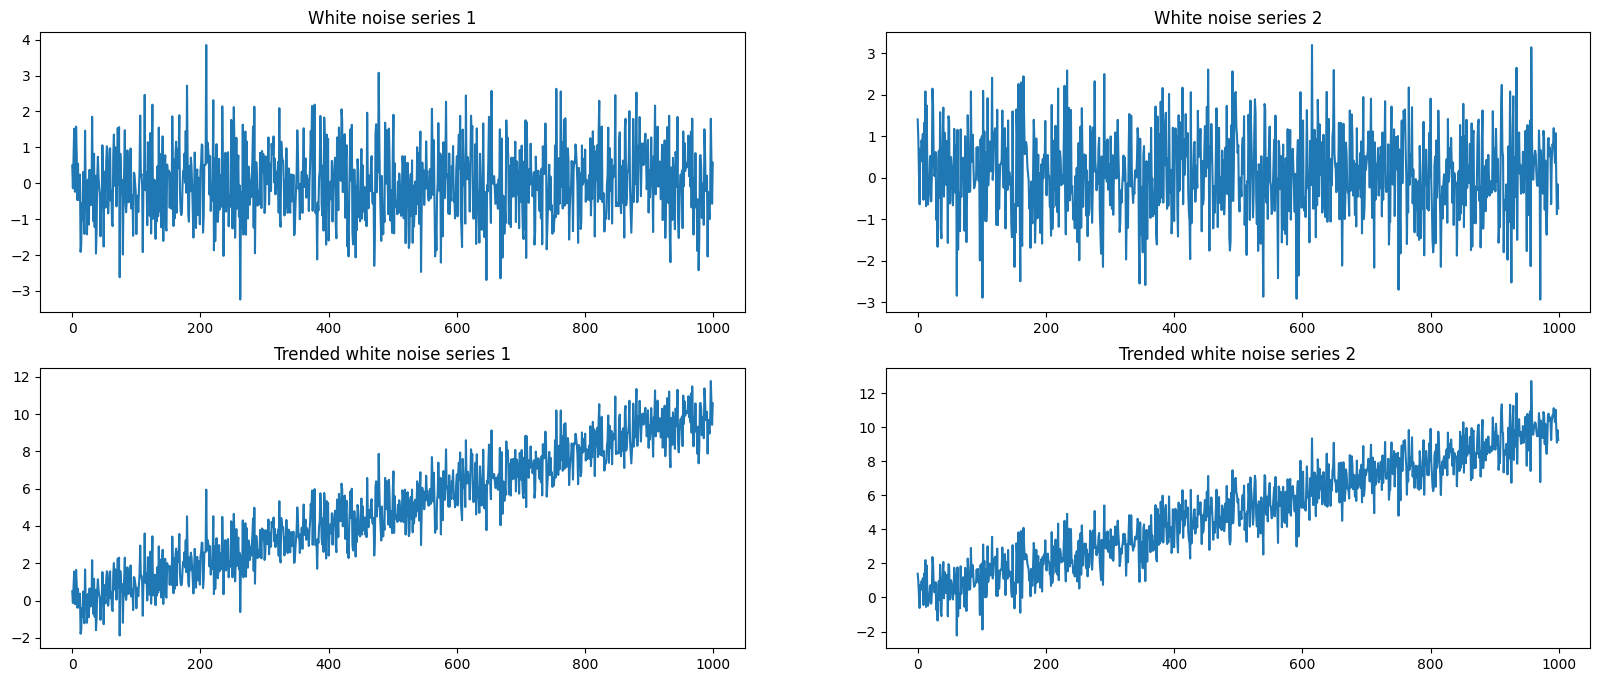

In [63]:
# plot the white noise series and the trended white noise series
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
axs[0, 0].plot(wn1)
axs[0, 0].set_title("White noise series 1")
axs[0, 1].plot(wn2)
axs[0, 1].set_title("White noise series 2")
axs[1, 0].plot(wn1_trend)
axs[1, 0].set_title("Trended white noise series 1")
axs[1, 1].plot(wn2_trend)
axs[1, 1].set_title("Trended white noise series 2")
plt.show()

In [64]:
# calculate correlation between the two trended white noise series
corr2 = np.corrcoef(wn1_trend, wn2_trend)[0, 1]
print("Correlation between trended white noise series: {:.3f}".format(corr2))


Correlation between trended white noise series: 0.891


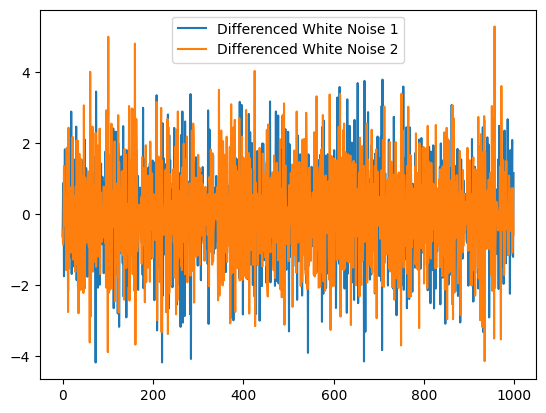

In [65]:
# Difference the white noise series with trend
diff_1 = np.diff(wn1_trend)
diff_2 = np.diff(wn2_trend)

# Plot the differenced time series
plt.plot(diff_1, label='Differenced White Noise 1')
plt.plot(diff_2, label='Differenced White Noise 2')
plt.legend()
plt.show()

In [66]:
# Calculate the correlation between the differenced time series
corr_diff = np.corrcoef(diff_1, diff_2)[0, 1]
print(f"The correlation between the differenced time series is {corr_diff}.")

The correlation between the differenced time series is -0.0214771676626417.


In [67]:
# to escape the spurious correlation trap
# we should difference the time series to detrend it or make it stationary before we check for correlation.

In [68]:
differenced = df_resample_months.diff()

In [69]:
differenced

,MSFT_Spline,SPY_Spline
2014-01-01,NaN,NaN
2014-02-01,1.095,0.085
2014-03-01,1.175,3.225
2014-04-01,1.195,0.245
2014-05-01,0.005,2.115
...,...,...
2024-09-01,15.730,7.790
2024-10-01,-11.420,19.150
2024-11-01,0.225,15.860
2024-12-01,19.875,7.780


<Axes: >

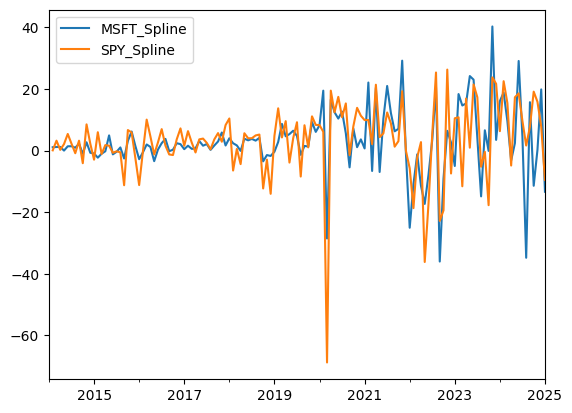

In [70]:
differenced.plot()

In [71]:
np.corrcoef(differenced['MSFT_Spline'].dropna(),differenced['SPY_Spline'].dropna())

array([[1.        , 0.63672855],
       [0.63672855, 1.        ]])

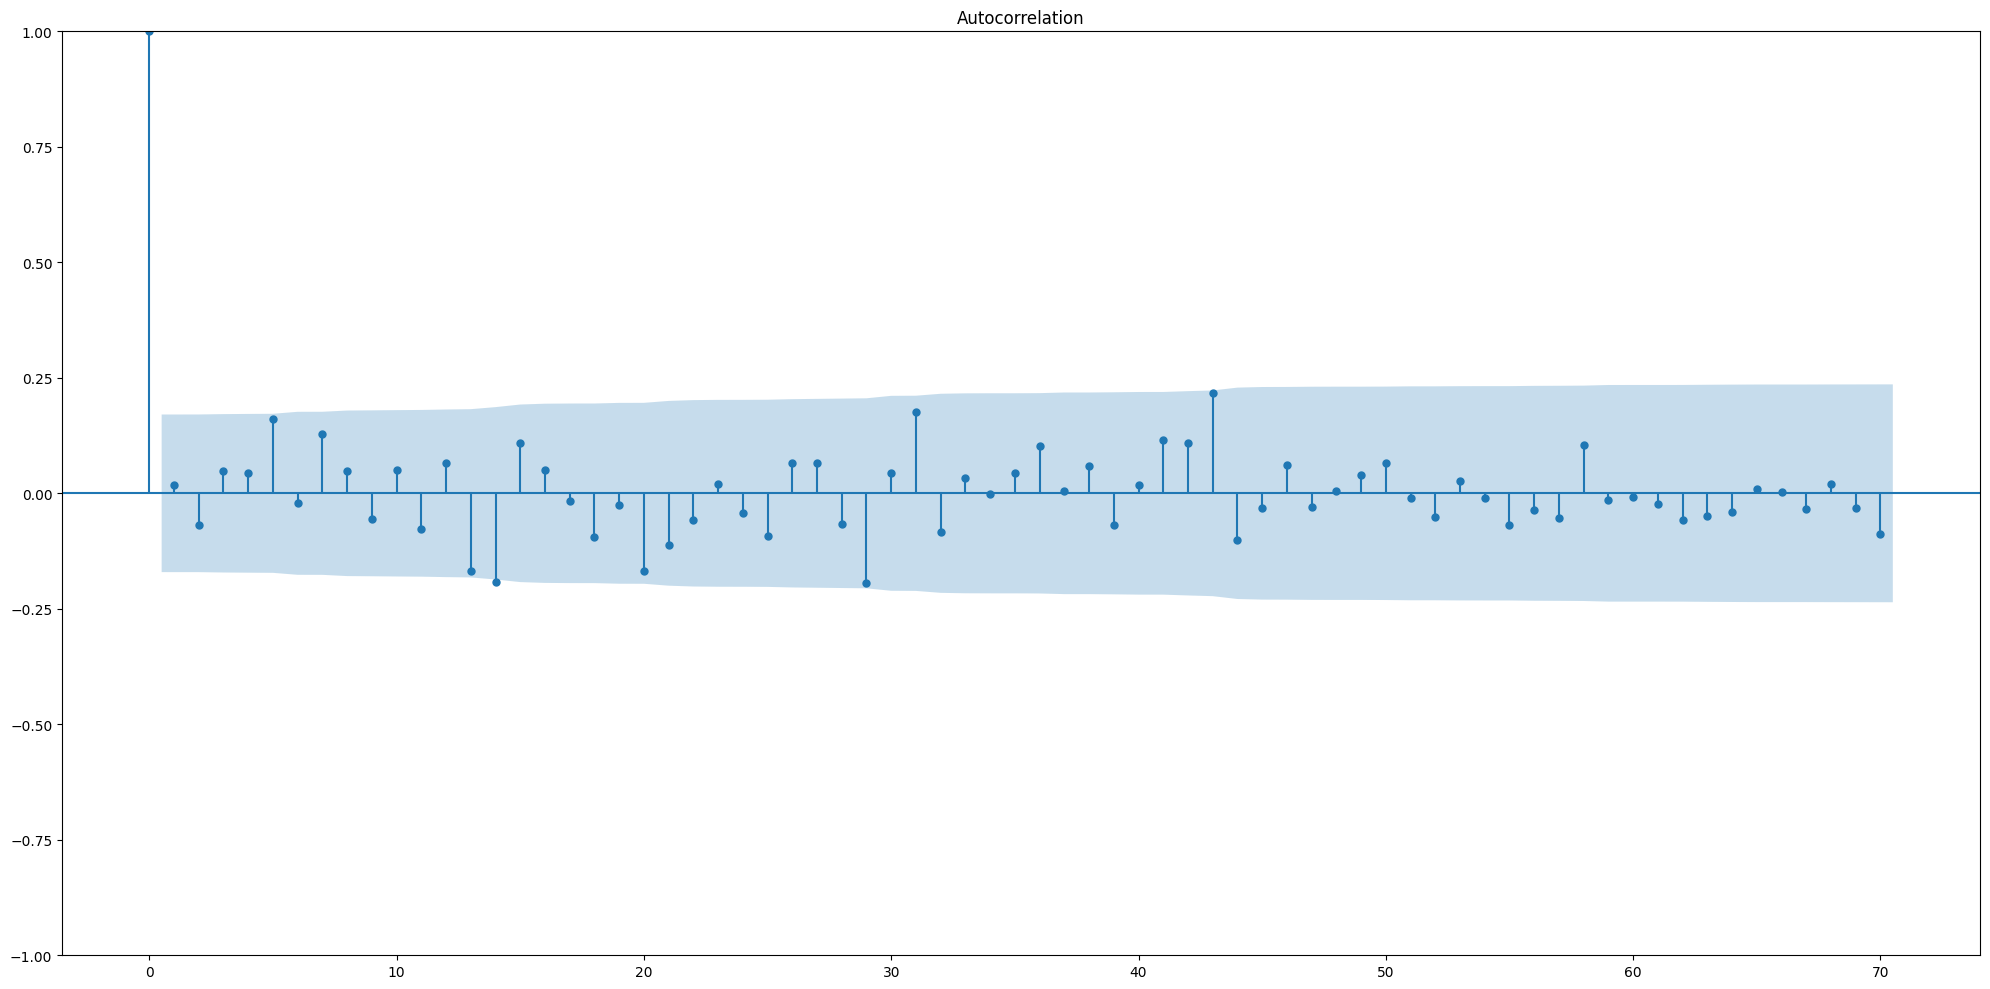

In [72]:
# Calculate the ACF (via statsmodel)
# Source: https://www.alpharithms.com/autocorrelation-time-series-python-432909/

fig = plot_acf(differenced['SPY_Spline'].dropna(), lags=70)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

## Split data into train and test sets

In [73]:
# let us select just one series - SPY

In [74]:
spy = spy_df[['SPY_Spline']]
spy

,SPY_Spline
2014-01-01,150.810
2014-02-01,150.895
2014-03-01,154.120
2014-04-01,154.365
2014-05-01,156.480
...,...
2024-09-01,558.550
2024-10-01,577.700
2024-11-01,593.560
2024-12-01,601.340


In [75]:
from sklearn.model_selection import train_test_split

# Create a test set of 12 data points
test_size = 12

train_data, test_data = train_test_split(spy, test_size=test_size, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 121
No. of testing examples: 12


In [76]:
train_data

,SPY_Spline
2014-01-01,150.810
2014-02-01,150.895
2014-03-01,154.120
2014-04-01,154.365
2014-05-01,156.480
...,...
2023-09-01,436.400
2023-10-01,418.680
2023-11-01,442.460
2023-12-01,464.150


In [77]:
test_data

,SPY_Spline
2024-02-01,493.000
2024-03-01,508.430
2024-04-01,503.585
2024-05-01,520.910
2024-06-01,539.495
2024-07-01,549.120
2024-08-01,550.760
2024-09-01,558.550
2024-10-01,577.700
2024-11-01,593.560


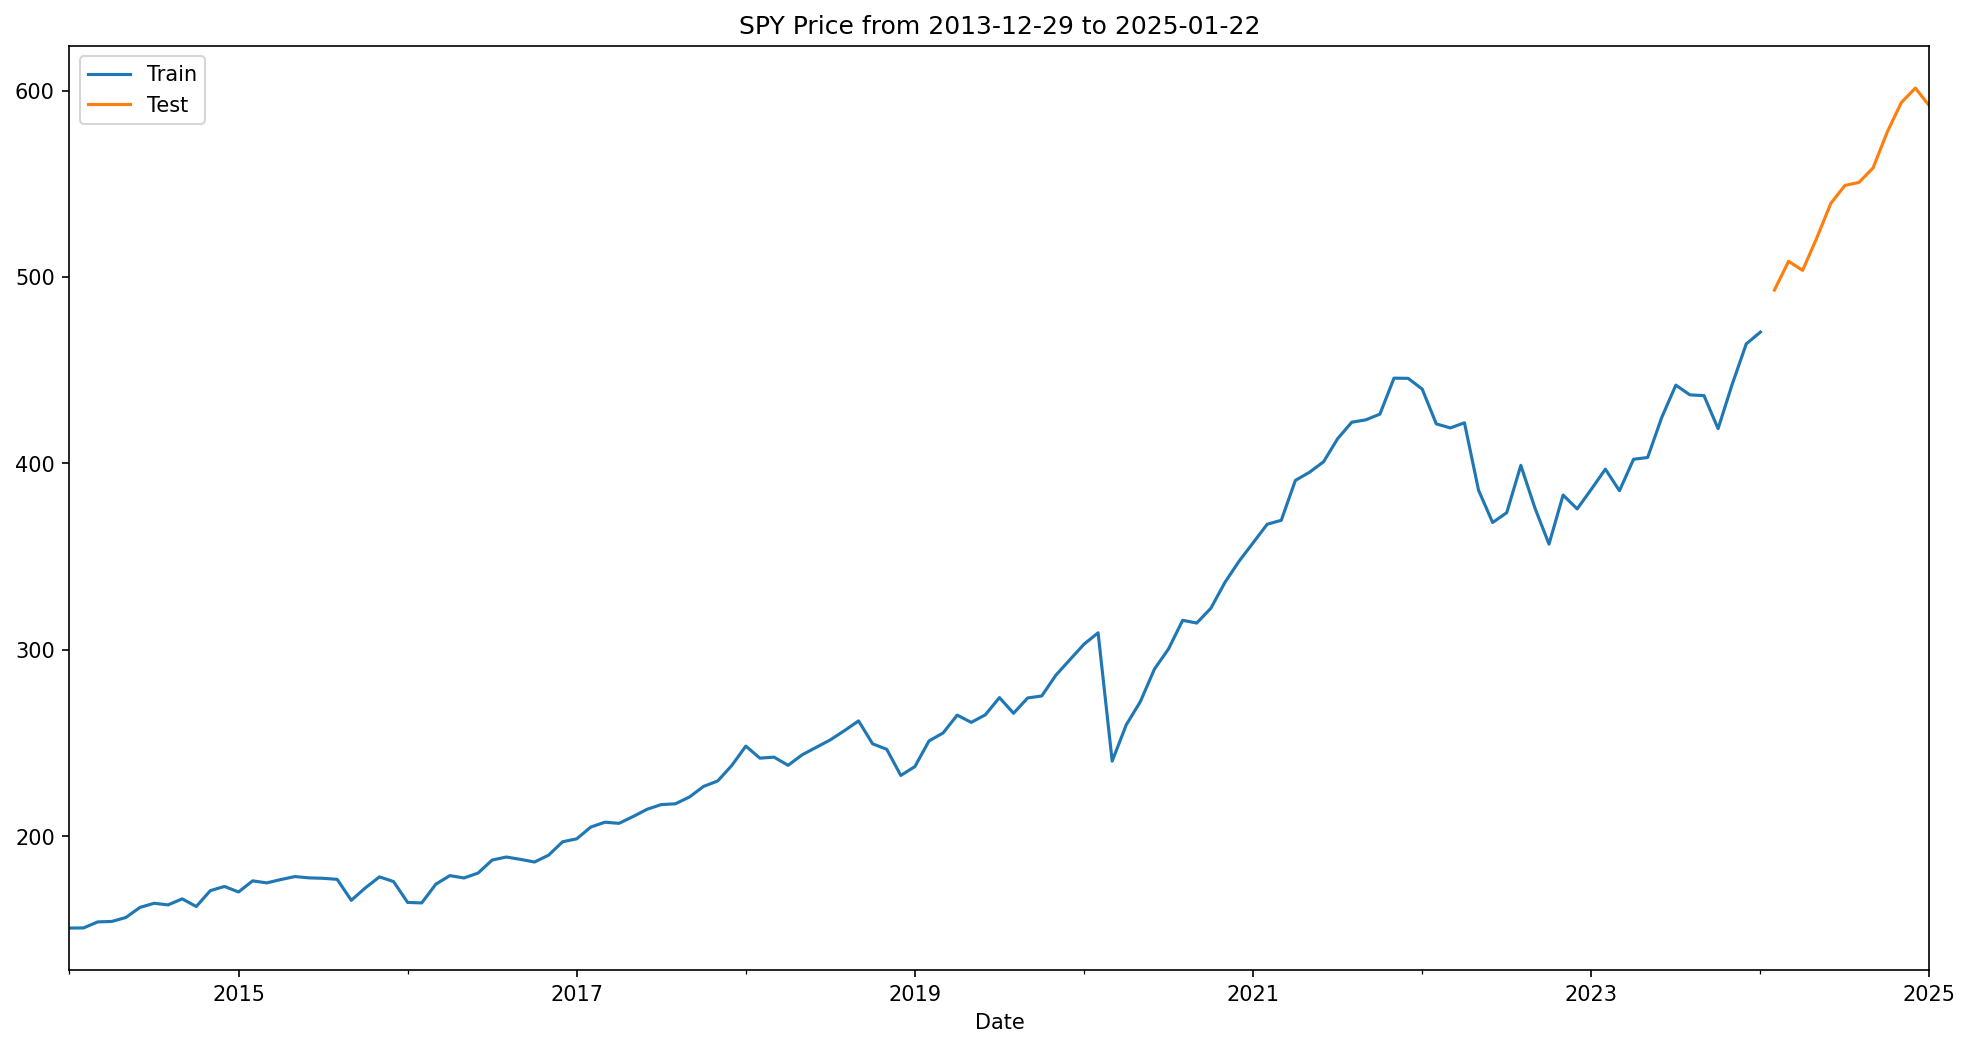

In [78]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
train_data['SPY_Spline'].plot(label='Train')
test_data['SPY_Spline'].plot(label='Test')


# adding title to the plot
plt.title('SPY Price from {} to {}'.format(stock_start_date, stock_end_date))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


## Fitting Models - Exponential Smoothing Models

### ETS - Error, Trend, Seasonailty

Exponential smoothing was proposed in the late 1950s, and has motivated some of the most successful forecasting methods. Exponential smoothing is a time series forecasting method for univariate data. Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight.

The weights are controlled by the smoothing parameter which is known as 'alpha'. alpha value can be between 0 to 1:

1. (alpha)=0: Means that forecast for future value is the average of historical data.
2. (alpha)=1: Means that forecast for all future value is the value of the last observation   

Source:
1. https://analyticsindiamag.com/hands-on-guide-to-time-series-analysis-using-simple-exponential-smoothing-in-python/#:~:text=Simple%20Exponential%20Smoothing%20(SES)%20is,statsmodel%20using%20pip%20install%20statsmodel.&text=Simple%20Exponential%20Smoothing%20is%20defined,where%20we%20will%20import%20it.
2. https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

#### Simple Exponential Smoothing

The simplest of the exponentially smoothing methods is naturally called simple exponential smoothing (SES). This method is suitable for forecasting data with no clear trend or seasonal pattern.

For creating a prediction model using SES we should have an (alpha) value which can be hyper parameter tuned. Here we will create three instances in which we will take three different (alpha) values as:

1. (alpha) = 0.2
2. (alpha) = 0.5
3. (alpha) value automatically optimized by statsmodel which is the recommended one.

We will pass the data into Simple Exponential Smoothing and fit the data with different values of the Smoothing Level.

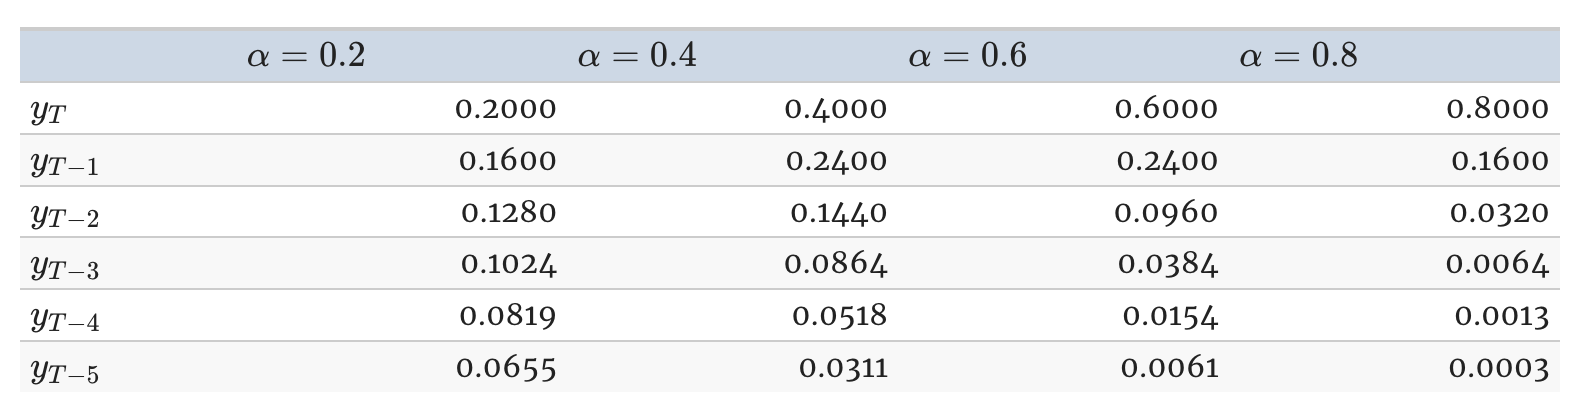

In [79]:
#First Instance
ins1 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2,optimized=False)
ins_cast1 = ins1.forecast(12).rename('alpha=0.2')

#Second Instance
ins2 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.5,optimized=False)
ins_cast2 = ins2.forecast(12).rename('alpha=0.5')

#Third Instance
ins3 = SimpleExpSmoothing(train_data).fit()
ins_cast3 = ins3.forecast(12).rename('alpha=%s'%ins3.model.params['smoothing_level'])


In [80]:
ins_cast1

,alpha=0.2
2024-02-01,439.06025
2024-03-01,439.06025
2024-04-01,439.06025
2024-05-01,439.06025
2024-06-01,439.06025
2024-07-01,439.06025
2024-08-01,439.06025
2024-09-01,439.06025
2024-10-01,439.06025
2024-11-01,439.06025


In [81]:
test_data

,SPY_Spline
2024-02-01,493.000
2024-03-01,508.430
2024-04-01,503.585
2024-05-01,520.910
2024-06-01,539.495
2024-07-01,549.120
2024-08-01,550.760
2024-09-01,558.550
2024-10-01,577.700
2024-11-01,593.560


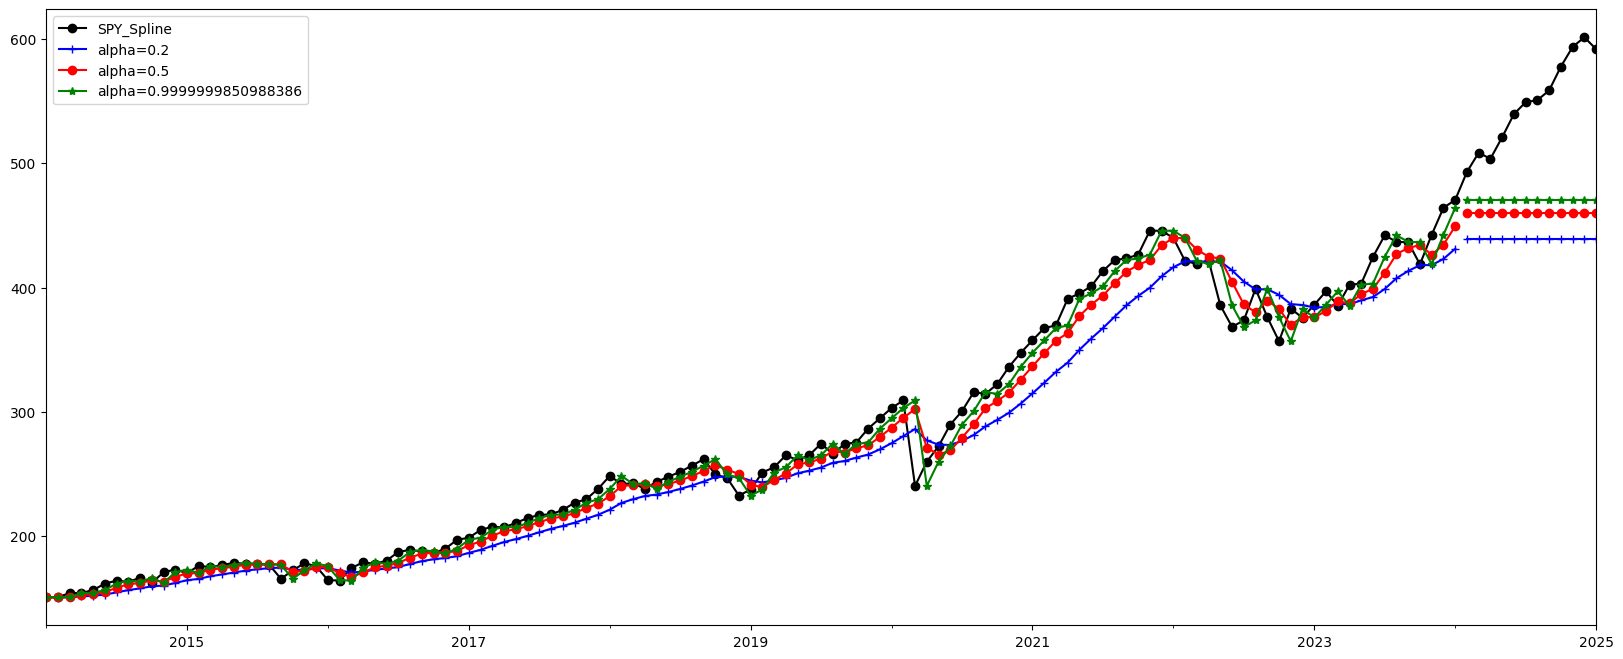

In [82]:
#After creating model we will visualize the plot
ax = spy.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for alpha =0.2
ins_cast1.plot(marker='+', ax=ax, color='blue', legend=True)
ins1.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for alpha = 0.5
ins_cast2.plot(marker='o', ax=ax, color='red', legend=True)
ins2.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.show()

In [83]:
'''
In terms of forecasting, simple exponential smoothing generates a constant set of values.
All forecasts equal the last value of the level component.
Consequently, these forecasts are appropriate only when your time series data have no trend or seasonality.
'''

'\nIn terms of forecasting, simple exponential smoothing generates a constant set of values.\nAll forecasts equal the last value of the level component.\nConsequently, these forecasts are appropriate only when your time series data have no trend or seasonality.\n'

#### Double Exponential Smoothing

This is the extended version of simple exponential smoothing to allow the forecasting of data with a trend. This method has two smoothing equations and hence two parameters, alpha and beta, (one for the level and one for the trend).

In [84]:
# Double ETS
# Let us fit the data on Double ES, on both Additive and Multiplicative Trend

In [85]:
double_ets_add = ExponentialSmoothing(train_data, trend = 'add').fit()
double_ets_mul = ExponentialSmoothing(train_data, trend = 'mul').fit()

double_ets_add_pred = double_ets_add.forecast(12)
double_ets_mul_pred = double_ets_mul.forecast(12)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


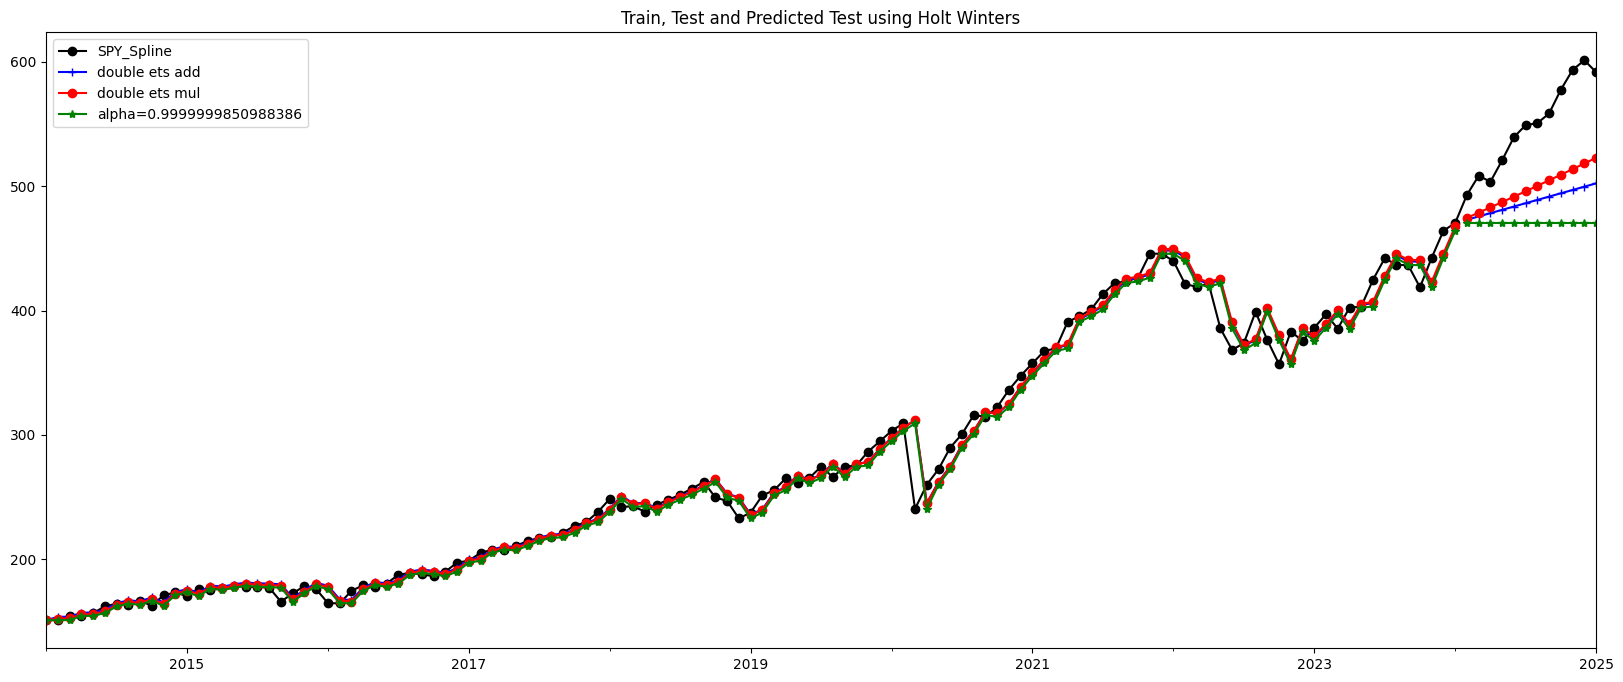

In [86]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = spy.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'double ets add')
double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'double ets mul')
double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()



#### Triple Exponential Smoothing

This is the extended version of simple exponential smoothing to allow the forecasting of data with a trend and seasonality. This method has three smoothing equations and hence three parameters - alpha, beta, and gamma. (one each for the level, trend, and seasonality).

In [87]:
# triple ETS - Holt Winter's Seasonal Method
triple_ets_add = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred = triple_ets_add.forecast(12)
triple_ets_mul_pred = triple_ets_mul.forecast(12)


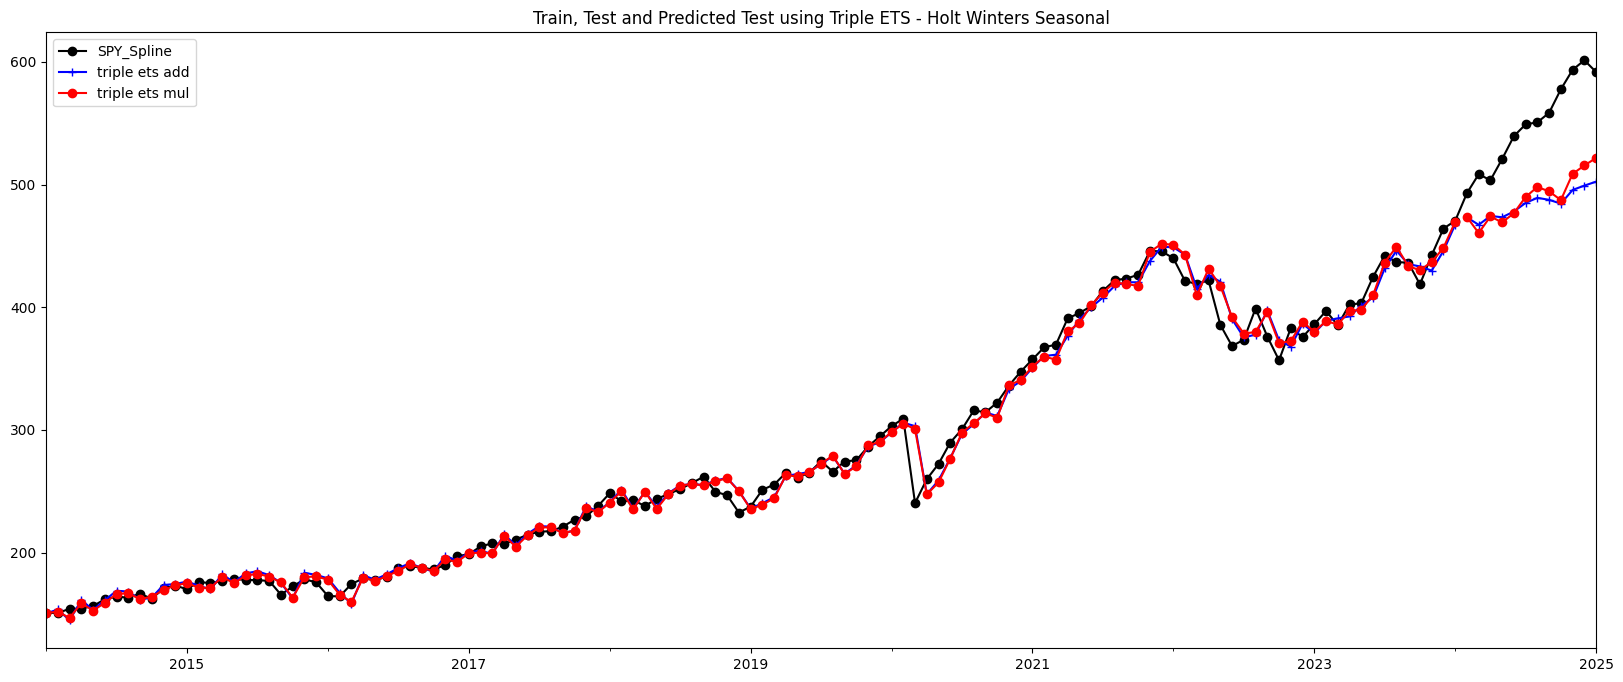

In [88]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = spy.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')
triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')
triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
#ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
#ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

## Visualize Forecast Errors

Source: https://machinelearningmastery.com/visualize-time-series-residual-forecast-errors-with-python/

In [89]:
# Residual Plots / Residual Diagnostics. What are residuals?

In [90]:
test_data

,SPY_Spline
2024-02-01,493.000
2024-03-01,508.430
2024-04-01,503.585
2024-05-01,520.910
2024-06-01,539.495
2024-07-01,549.120
2024-08-01,550.760
2024-09-01,558.550
2024-10-01,577.700
2024-11-01,593.560


In [91]:
#calculate residuals
residuals = [test_data.values.flatten()[i]-triple_ets_add_pred.values.flatten()[i] for i in range(len(test_data))]
residuals = pd.DataFrame(residuals)

In [92]:
residuals

,0
0,19.718927
1,41.212586
2,29.169454
3,47.523477
4,61.447530
5,64.031002
6,61.562379
7,70.970708
8,93.235252
9,97.910527


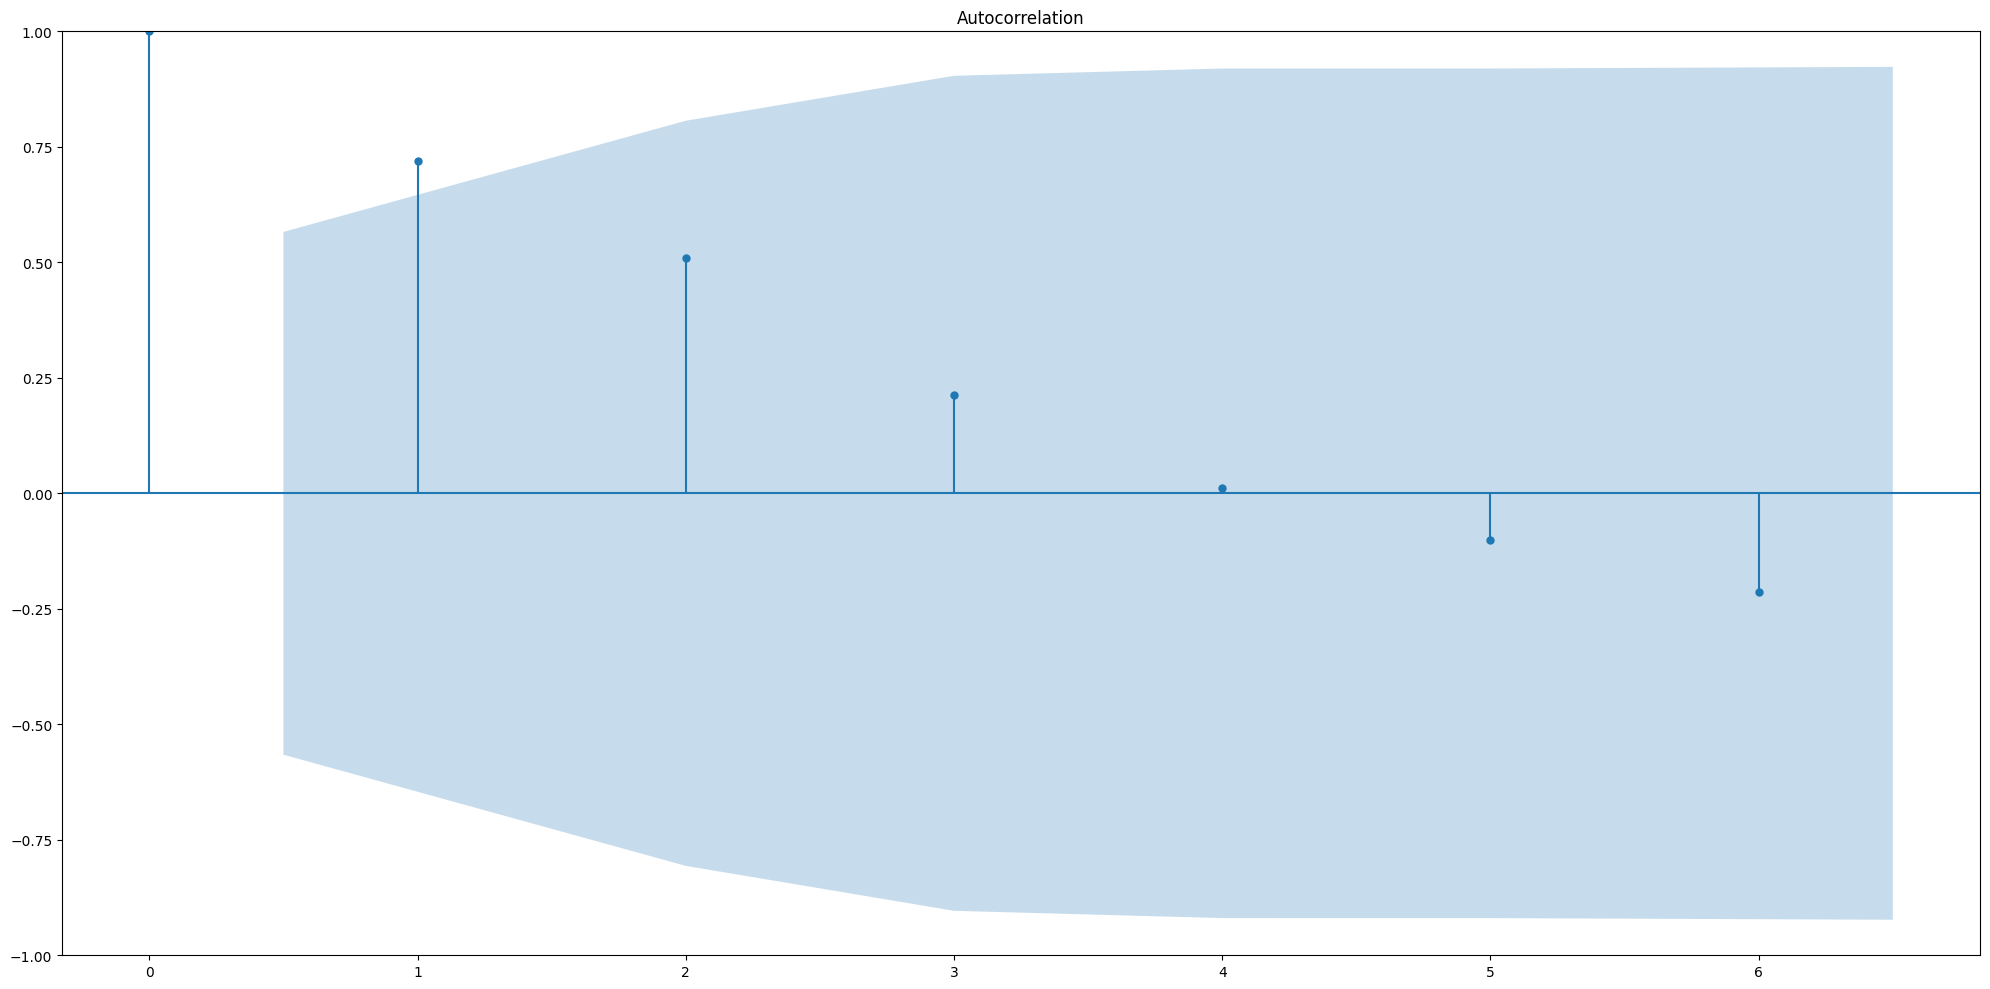

In [93]:

fig = plot_acf(residuals)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

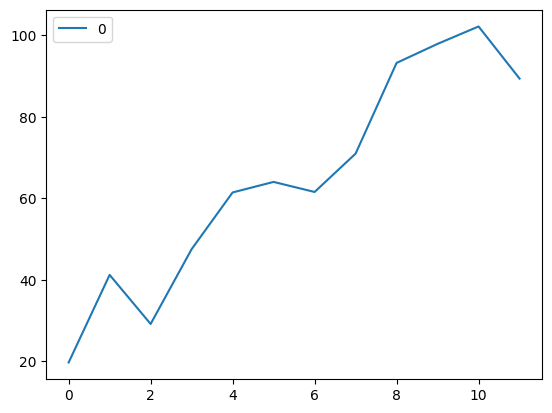

In [94]:
# plot residuals
residuals.plot()
plt.show()

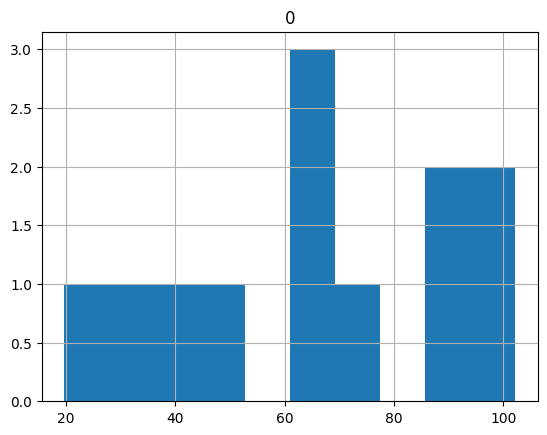

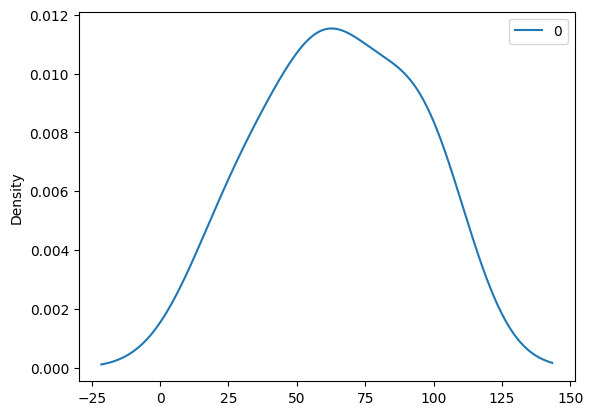

In [95]:
# histogram plot
residuals.hist()
plt.show()
# density plot
residuals.plot(kind='kde')
plt.show()

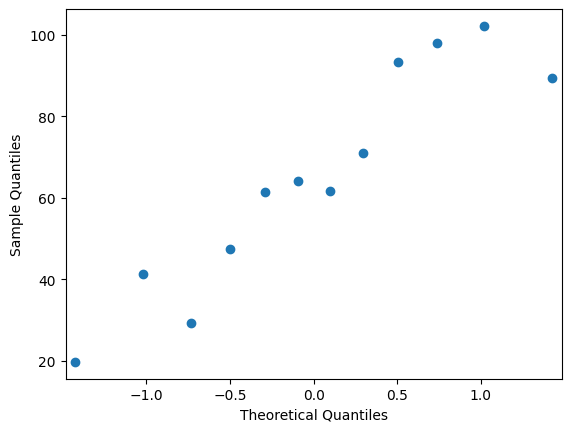

In [96]:
qqplot(residuals)
plt.show()

### Metrics - model evaluation

1. Root Mean Squared Error (RMSE) represents the sample standard deviation of the differences between predicted values and observed values. These individual differences are called residuals when the calculations are performed over the data sample that was used for estimation, and are called prediction errors when computed out-of-sample. This is a great measurement to use when comparing models as it shows how many deviations from the mean the forecasted values fall.
2. Mean Absolute Error (MAE) takes the sum of the absolute difference from actual to forecast and averages them. It is less sensitive to the occasional very large error because it does not square the errors in the calculation.
3. Mean Absolute Percentage Error (MAPE) is also often useful for purposes of reporting, because it is expressed in generic percentage terms it will make sense even to someone who has no idea what constitutes a "big" error in terms of dollars spent or widgets sold.

In [97]:
#define metrics dataframe which will be used below for storing results
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])

def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    df = pd.DataFrame({'Model': [model],
                       'RMSE': [rmse],
                       'MAE': [mae],
                       'MAPE': [mape]})

    global metrics_dataframe
    metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)
    return metrics_dataframe

In [98]:
#get all the metrics
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast1.values.flatten(),
                                'Simple 0.2')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast2.values.flatten(),
                                'Simple 0.5')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast3.values.flatten(),
                                'Simple 1')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                double_ets_add_pred.values.flatten(),
                                'Double Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                double_ets_mul_pred.values.flatten(),
                                'Double Mul')


metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_add_pred.values.flatten(),
                                'Triple Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_mul_pred.values.flatten(),
                                'Triple Mul')


<ipython-input-97-fea93f9d2c6b>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)


In [99]:
metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE
4,Double Mul,54.809032,50.667732,9.020936
6,Triple Mul,63.353787,59.860294,10.720299
3,Double Add,66.884503,61.360804,10.907051
5,Triple Add,69.886514,64.862537,11.557235
2,Simple 1,86.245381,78.560417,13.945421
1,Simple 0.5,95.986104,89.144857,15.881483
0,Simple 0.2,115.575798,109.960167,19.688933


In [100]:
spy.tail(12).mean()


,0
SPY_Spline,549.020417


In [101]:
triple_ets_add_pred.values.flatten()

array([473.28107271, 467.21741388, 474.41554631, 473.38652341,
       478.04746991, 485.08899807, 489.19762075, 487.57929181,
       484.46474785, 495.64947277, 499.1618121 , 502.40458979])

In [102]:
# Create a data frame with all the predictions along with the test data
test_pred_df = test_data.copy()

# Add all predictions
test_pred_df = test_pred_df.assign(triple_ets_mul_pred = triple_ets_mul_pred.values.flatten(),
                                   SimpleExp_1_pred = ins_cast3.values.flatten(),
                                   double_ets_mul_pred = double_ets_mul_pred.values.flatten())

test_pred_df

,SPY_Spline,triple_ets_mul_pred,SimpleExp_1_pred,double_ets_mul_pred
2024-02-01,493.000,473.564799,470.46,474.532029
2024-03-01,508.430,460.509474,470.46,478.736378
2024-04-01,503.585,474.054613,470.46,482.977978
2024-05-01,520.910,469.130104,470.46,487.257158
2024-06-01,539.495,476.744855,470.46,491.574252
2024-07-01,549.120,489.955985,470.46,495.929595
2024-08-01,550.760,498.072781,470.46,500.323527
2024-09-01,558.550,494.449512,470.46,504.756388
2024-10-01,577.700,487.381772,470.46,509.228525
2024-11-01,593.560,508.764604,470.46,513.740285


In [103]:
# Create an average prediction from the three and check it's metrics
test_pred_df['Average_Predictions'] = (test_pred_df['SimpleExp_1_pred']+test_pred_df['triple_ets_mul_pred']+test_pred_df['double_ets_mul_pred'])/3
test_pred_df


,SPY_Spline,triple_ets_mul_pred,SimpleExp_1_pred,double_ets_mul_pred,Average_Predictions
2024-02-01,493.000,473.564799,470.46,474.532029,472.852276
2024-03-01,508.430,460.509474,470.46,478.736378,469.901951
2024-04-01,503.585,474.054613,470.46,482.977978,475.830864
2024-05-01,520.910,469.130104,470.46,487.257158,475.615754
2024-06-01,539.495,476.744855,470.46,491.574252,479.593036
2024-07-01,549.120,489.955985,470.46,495.929595,485.448527
2024-08-01,550.760,498.072781,470.46,500.323527,489.618769
2024-09-01,558.550,494.449512,470.46,504.756388,489.888633
2024-10-01,577.700,487.381772,470.46,509.228525,489.023432
2024-11-01,593.560,508.764604,470.46,513.740285,497.654963


In [104]:
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                test_pred_df['Average_Predictions'].values.flatten(),
                                'Average')

metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE
4,Double Mul,54.809032,50.667732,9.020936
6,Triple Mul,63.353787,59.860294,10.720299
3,Double Add,66.884503,61.360804,10.907051
7,Average,67.932472,63.029481,11.228885
5,Triple Add,69.886514,64.862537,11.557235
2,Simple 1,86.245381,78.560417,13.945421
1,Simple 0.5,95.986104,89.144857,15.881483
0,Simple 0.2,115.575798,109.960167,19.688933


In [105]:
# write data to csv and excel
#test_pred_df.to_csv('/Users/shaikht1/Downloads/test.csv', index = True, header=True)
#test_pred_df.to_excel('/Users/shaikht1/Downloads/test.xlsx', index = True, header=True)